Q-learning is a reinforcement learning paradigm in which we learn a function:

$$Q^\pi(s, a)$$

Where $Q$ is the quality of an action $a$ given that we are in a (known) state $s$. The quality of an action is the expected value of the reward of a continuing the policy $\pi$ after the next step. Consider the relationship between the $Q(s, a)$ function and the value function $V(s)$:

$$Q(s, \pi(s)) = V^\pi(s)$$

If we mess with the left hand side policy $\pi$ for just the very next move, we might be able to find a better policy. Q learning leverages this simple idea: focus on just the next move, then let the chips fall where they may. Iterate.

Let's implement this.

In [4]:
%matplotlib inline

# Standard imports.
import numpy as np
import pylab
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Resize plots.
pylab.rcParams['figure.figsize'] = 12, 7

In [220]:
def qlearning(reward_transition_function, 
              policy_function, 
              gamma,
              alpha,
              nstates,
              nactions,
              niter = 1000,
              state = None,
              Q = None,
             ):
    """Implement a generic Q-learning algorithm.
    
    Q(state, action) is an nstates, nactions matrix.
    
    From Figure 6.12, Sutton & Barto.
    
    Args:
        reward_transition_function: a reward function taking arguments (action, state, step), 
            returning (reward, state_prime, is_terminal).
        policy_function: a policy function taking arguments (Q, state), returning policy a.
        gamma: a discount rate.
        alpha: a learning rate parameter.
        nstates: the number of states.
        nactions: the number of actions.
        niter: the maximum number of iterations to perform.
        state: the initial state.
        Q: an initial estimate of Q.
    
    Returns:
        (Q, actions, states, rewards)
    """
    if Q is None:
        Q = np.zeros((nstates, nactions))
    
    if state is None:
        state = int(np.random.rand() * nstates)
    
    actions = np.zeros(niter)
    states = np.zeros(niter)
    rewards = np.zeros(niter)
    
    for i in range(niter):
        action = policy_function(Q, state)
        reward, state_prime, is_terminal = reward_transition_function(action, state, i)
        actions[i] = action
        rewards[i] = reward
        states[i] = state_prime
            
        Q[state, action] = Q[state, action] + alpha * (reward + np.max(Q[state_prime, :]) - Q[state, action])
        state = state_prime
        
        if is_terminal:
            # terminal state
            break
         
    return (Q, actions, states, rewards)

def test_qlearning():
    """Unit test."""
    reward_transition_function = lambda x, y, z: (0, 0, False)
    policy_function = lambda x, y: 0
    gamma = 1
    nstates = 2
    nactions = 3
    niter = 10
    state = 1
    alpha = 0.1
    
    Q, actions, states, rewards = qlearning(reward_transition_function, 
                                              policy_function,
                                              gamma,
                                              alpha,
                                              nstates,
                                              nactions,
                                              niter,
                                              state
                                             )
    assert Q.shape[0] == nstates
    assert Q.shape[1] == nactions
    assert Q.sum() == 0
    assert actions.size == niter
    assert states.size == niter
    assert rewards.size == niter
    assert np.all(actions == 0)
    assert np.all(states == 0)
    assert np.all(rewards == 0)
    
test_qlearning()

Let's run this on a dummy problem - a 5 state linear grid world with the rewards:
    
    [-1  0  0  0  1]

Where we always start at the middle and must choose the left-right policy. We know the optimal strategy is to go right, of course.

In [222]:
def epsilon_greedy_policy(Q, state, epsilon = .1):
    """Epsilon-greedy policy."""
    if np.random.rand() > epsilon:
        return np.argmax(Q[state, :])
    else:
        return int(np.random.rand() * Q.shape[1])

nstates = 5
def left_right_world(action, state, step):
    # Implement a 5-state world in which there's a terminal reward -1,
    # a state to the right with terminal reward 1, and where you start in the middle.
    reward = 0
    is_terminal = False
    if action:
        # Go the right.
        next_state = state + 1
        if next_state == nstates - 1:
            # terminal reward!
            reward = 1
            is_terminal = True
    else:
        # Go the left.
        next_state = state - 1
        if next_state == 0:
            # terminal reward!
            reward = -1
            is_terminal = True
    return (reward, next_state, is_terminal)
            
# Do a number of episodes.
nepisodes = 100
Q = np.zeros((nstates, 2))
episodic_rewards = np.zeros(nepisodes)
for i in range(nepisodes):
    Q, actions, states, rewards = qlearning(left_right_world,
                                      epsilon_greedy_policy,
                                      1.0,
                                      0.1,
                                      nstates,
                                      2,
                                      niter = 50,
                                      state = int(nstates / 2),
                                      Q = Q)
    episodic_rewards[i] = rewards.sum()

Does it succesfully learn the task?

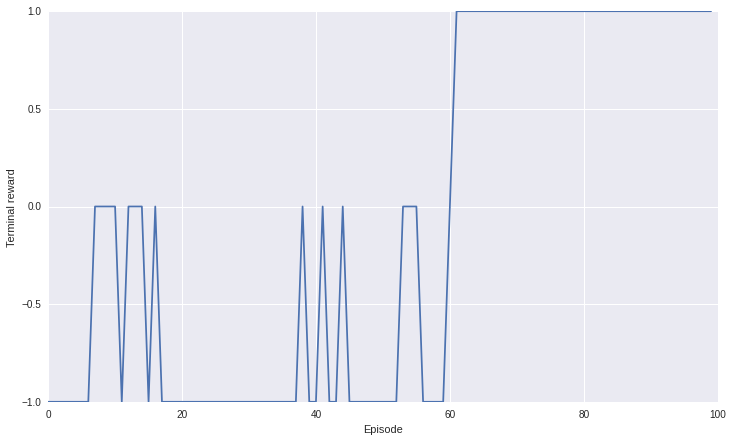

In [134]:
plt.plot(episodic_rewards)
plt.xlabel('Episode')
plt.ylabel('Terminal reward')

In [136]:
# The actions should be [1, 1], i.e. go right, go right
actions[0:2]

array([ 1.,  1.])

Let's look at the Q function.

In [137]:
Q

array([[  0.00000000e+00,   0.00000000e+00],
       [ -9.92144833e-01,   3.61235854e-02],
       [  1.90000000e-04,   9.12592063e-01],
       [  1.00000000e-03,   9.83576797e-01],
       [  0.00000000e+00,   0.00000000e+00]])

Interestingly, it hasn't fully learned the task - it should learn that moving left is always a bad idea, while it's only learned this for the state closest to the left-hand side terminal state. It doesn't need to know such things - it already has a good enough policy, so there's no need to learn about hypotheticals. This is a key difference between Q-learning and dynamic programming methods, which spend a lot of energy learning about situations which may never occur.

# OpenAI gym task - pole balancing

Let's try to apply this method to the cart pole balancing problem in the OpenAI gym. For reference, here's a (slightly adapted version of) the starter code at https://gym.openai.com/docs that uses a random policy:

In [181]:
import gym
env = gym.make('CartPole-v0')
nepisodes = 5
episodic_rewards = np.zeros((nepisodes))
for i_episode in range(nepisodes):
    observation = env.reset()
    cum_reward = 0
    for t in range(100):
        env.render()
        # print(observation)
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        cum_reward += reward
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
    episodic_rewards[i_episode] = cum_reward
env.render(close=True)

[2016-06-21 23:31:21,715] Making new env: CartPole-v0


Episode finished after 31 timesteps
Episode finished after 35 timesteps
Episode finished after 12 timesteps
Episode finished after 18 timesteps
Episode finished after 17 timesteps


The random policy doesn't work - let's try to first discretize the 4d state space into positive & negative hyperplanes - this will give a 16 D state space. Let's then apply Q-learning to this space.

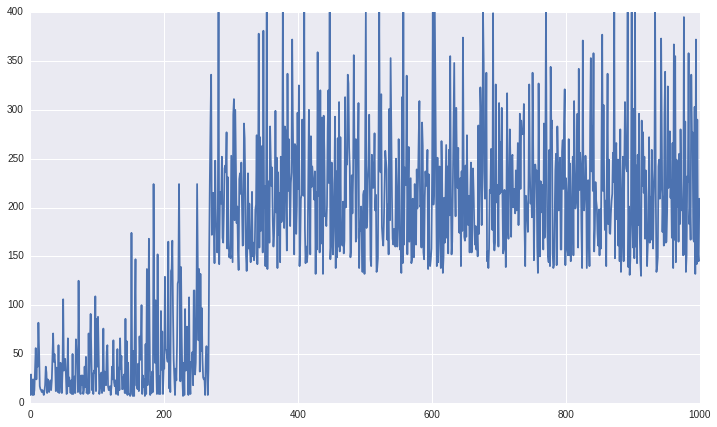

In [245]:
import functools

def observation_to_state(observation):
    """
    Project to 16 dimensional latent space
    """
    observation = (observation > 0) * 1
    return np.sum(observation * np.arange(4) ** 2)
    

nepisodes = 1000
episodic_rewards = np.zeros((nepisodes))
Q = np.zeros((16, env.action_space.n))

epsilon = .5
frames = []
for i_episode in range(nepisodes):
    observation = env.reset()
    niter = 0
    frames = []
    def reward_transition_function(action, _, step):
        observation, reward, done, _ = env.step(action)
        state_prime = observation_to_state(observation)
        if done:
            reward = step - 195.0
        if i_episode == nepisodes - 1:
            frames.append(
                env.render(mode = 'rgb_array')
            )
        return (reward, state_prime, done)
    
    state = observation_to_state(observation)
    Q, actions, states, rewards = qlearning(reward_transition_function,
              functools.partial(epsilon_greedy_policy, epsilon = epsilon),
              1,
              .4,
              16,
              env.action_space.n,
              niter = 400,
              state = state,
              Q = Q
             )
    # Decrease the amount of exploration when we get about halfway through the task
    if (rewards == 1).sum() > 100:
        epsilon *= .9
    
    episodic_rewards[i_episode] = (rewards == 1).sum()
plt.plot(episodic_rewards)

Display one example rollout. See here for how to do such a thing:

https://github.com/patrickmineault/xcorr-notebooks/blob/master/Render%20OpenAI%20gym%20as%20GIF.ipynb


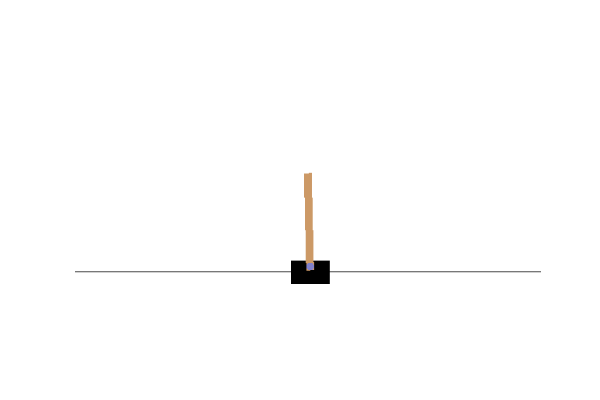
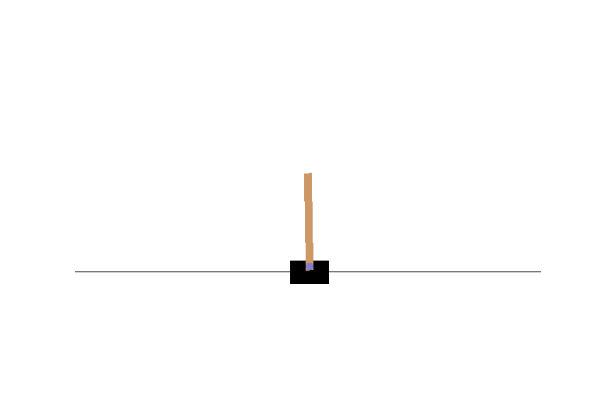
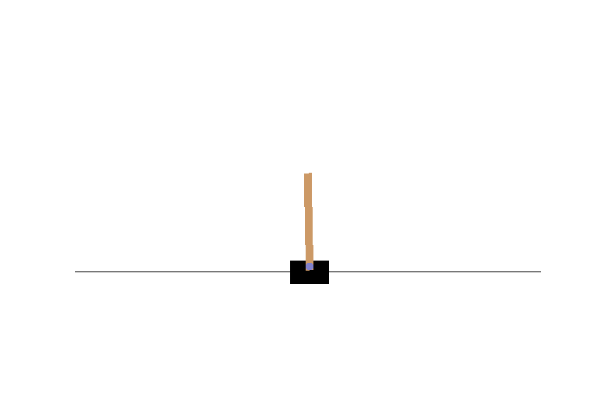
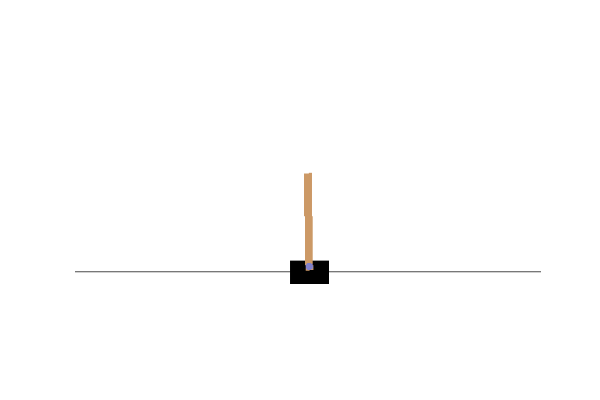
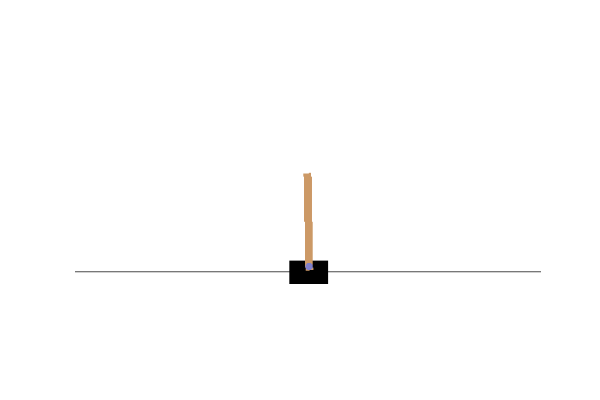
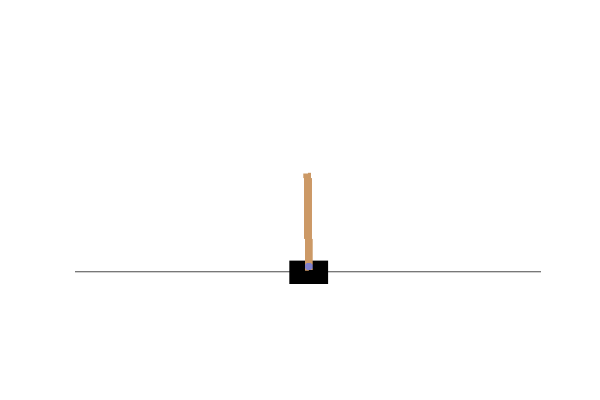
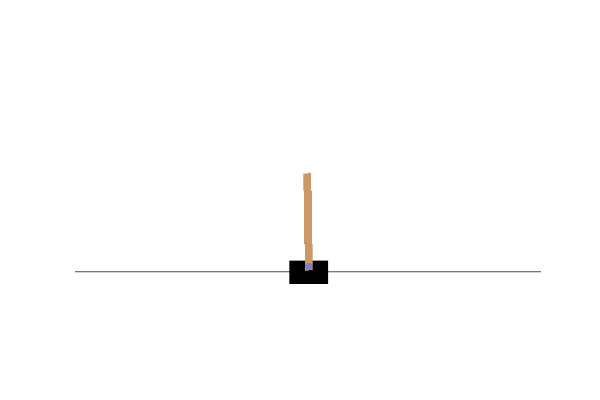
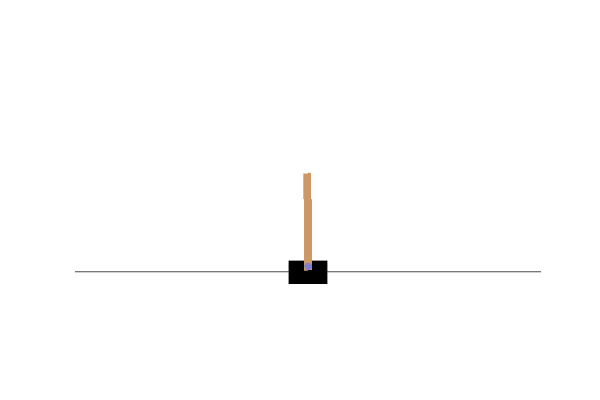
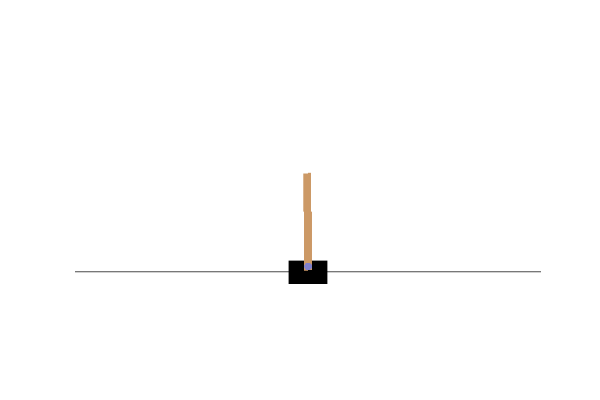
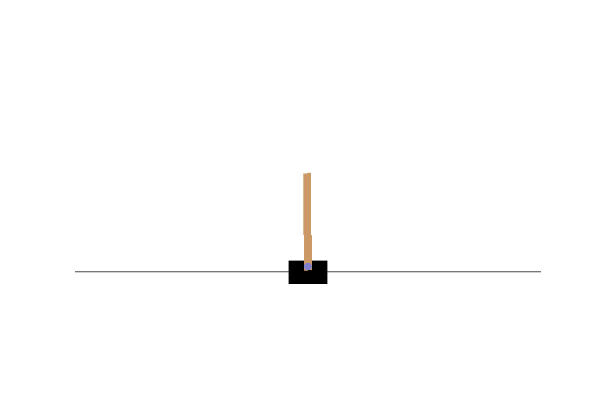
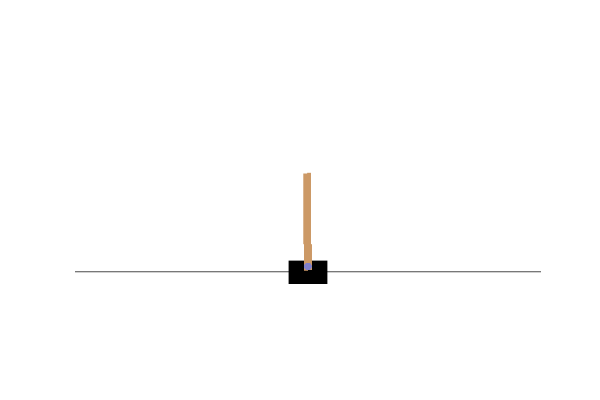
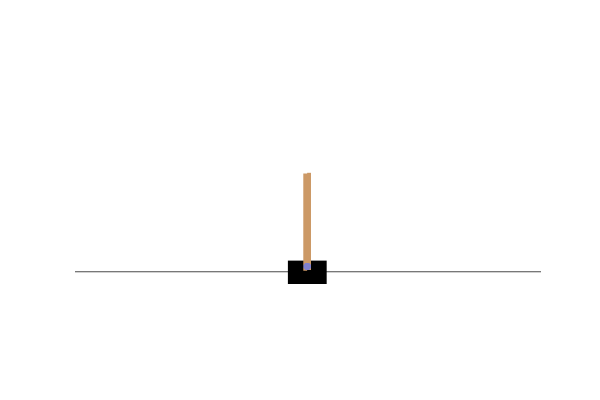
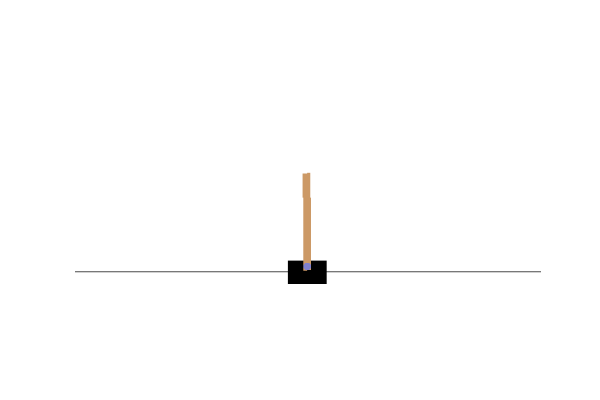
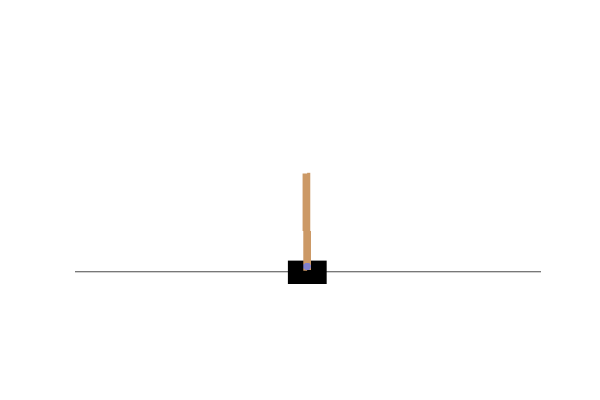
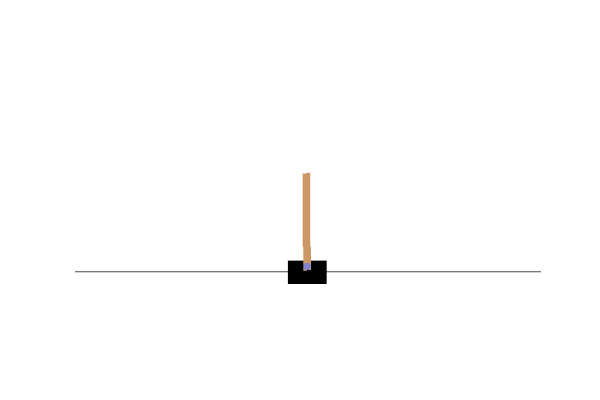
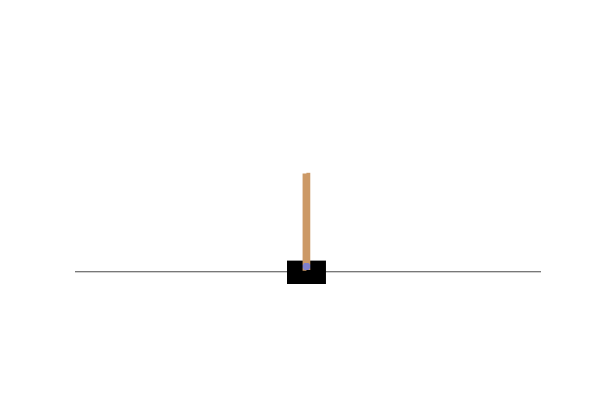
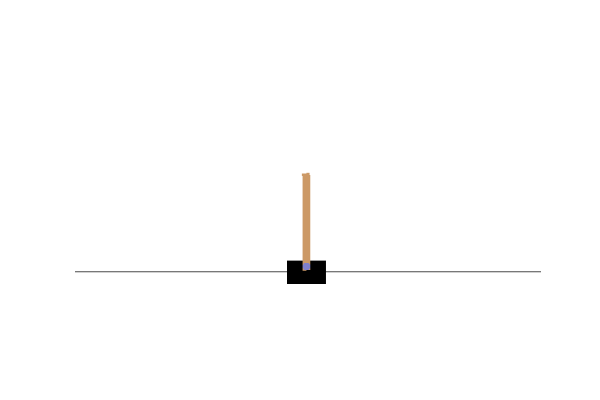
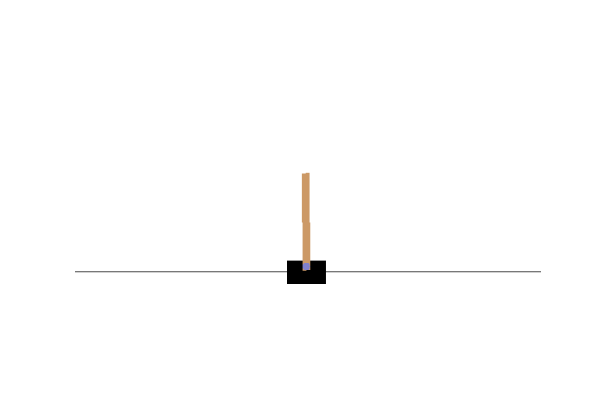
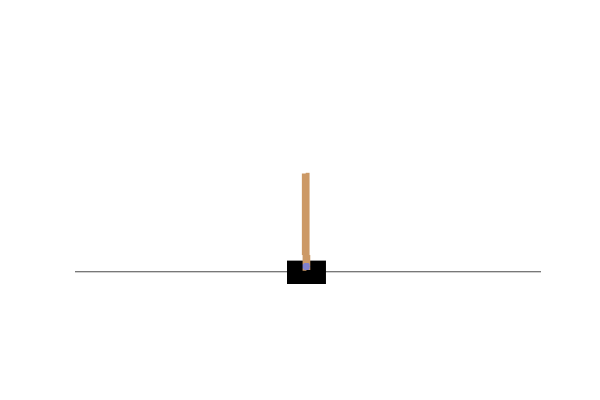
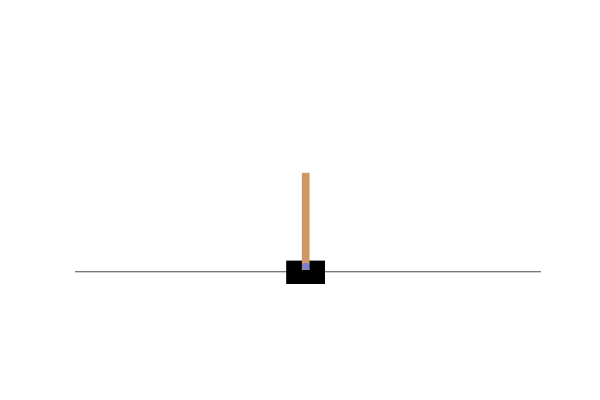
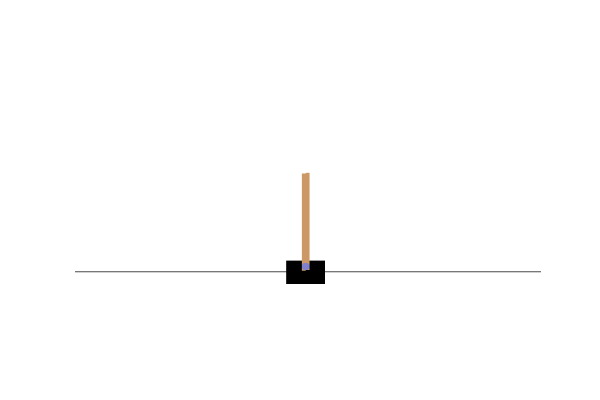
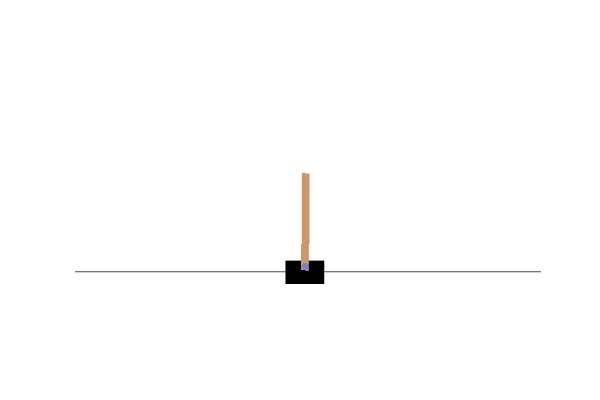
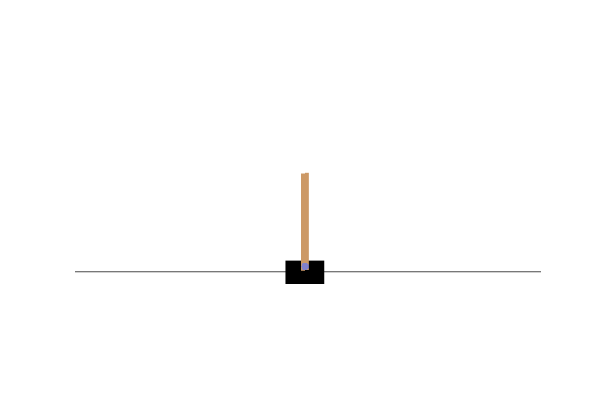
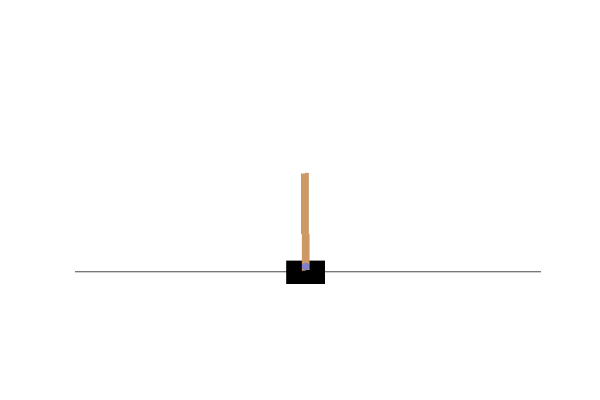
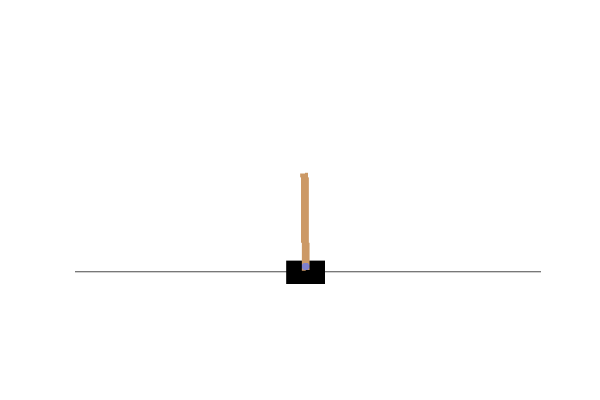
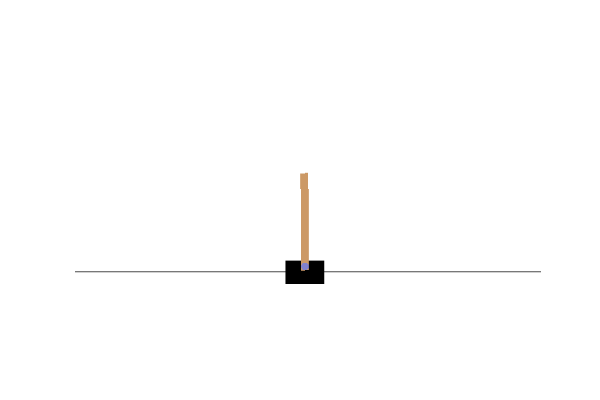
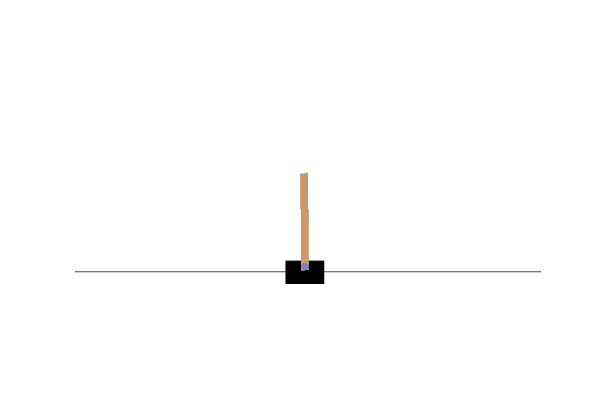
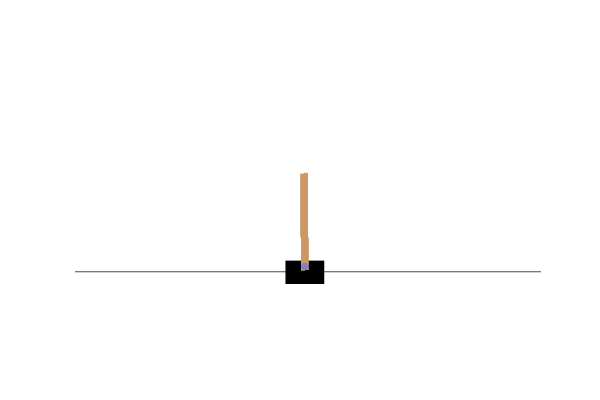
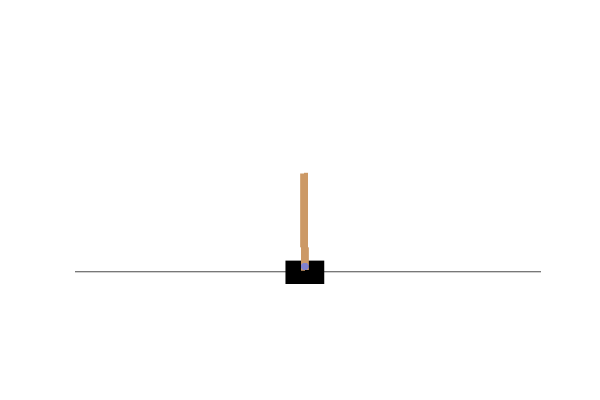
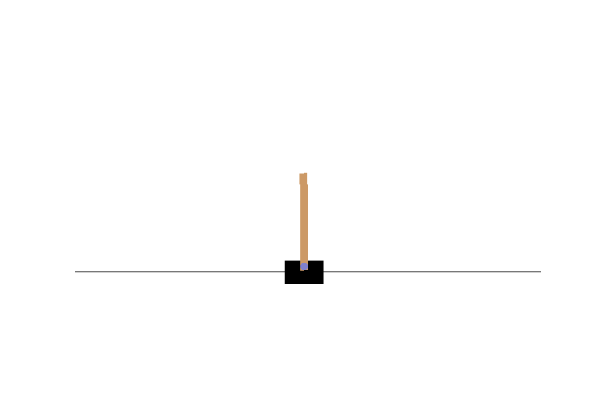
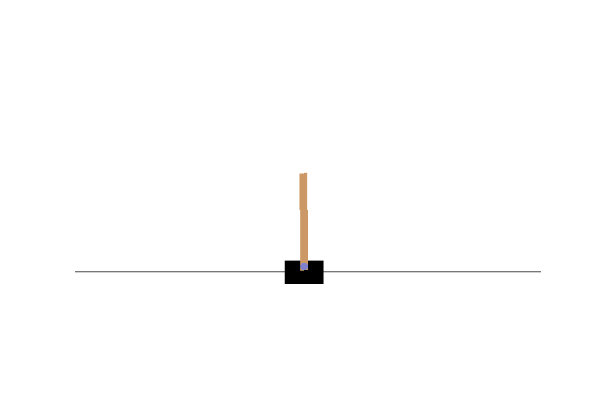
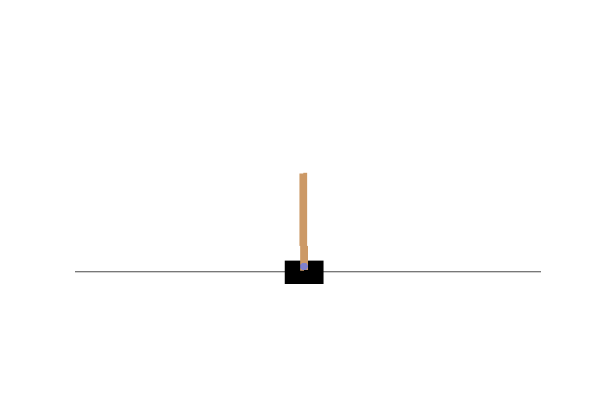
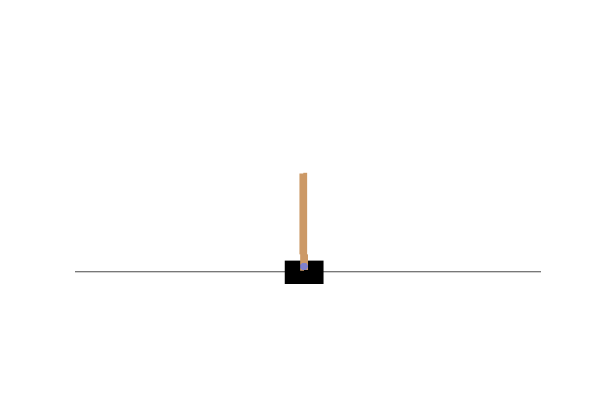
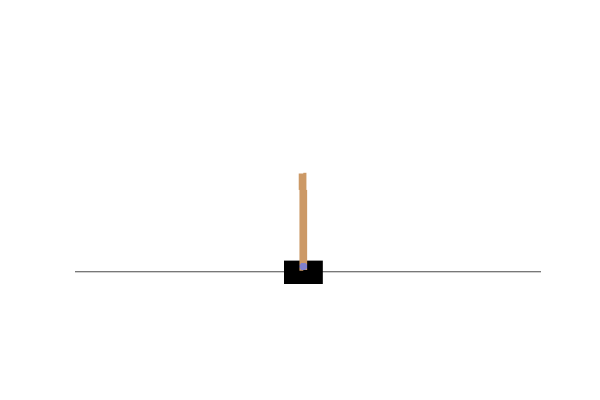
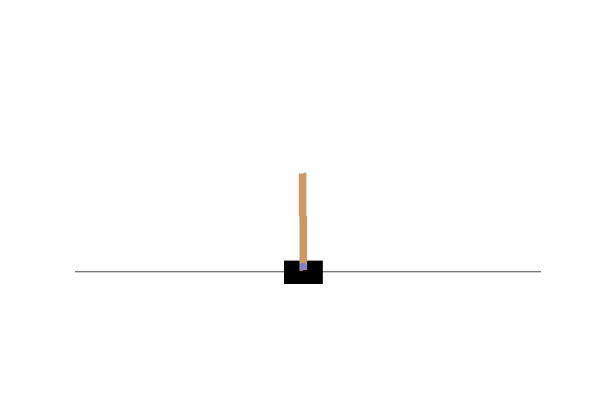
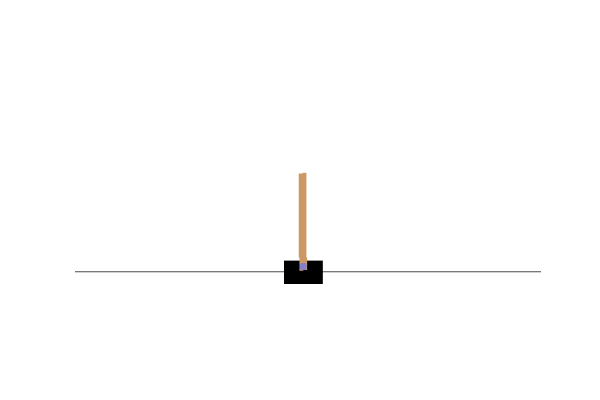
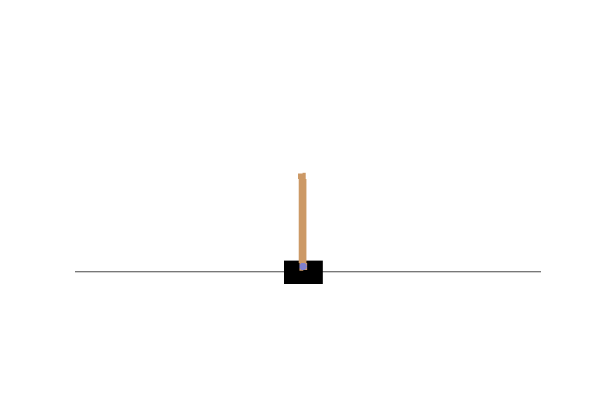
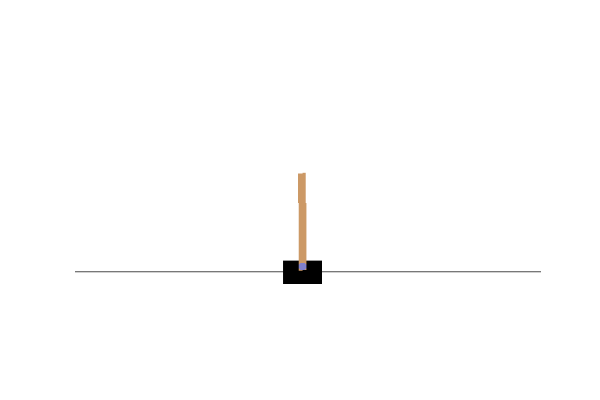
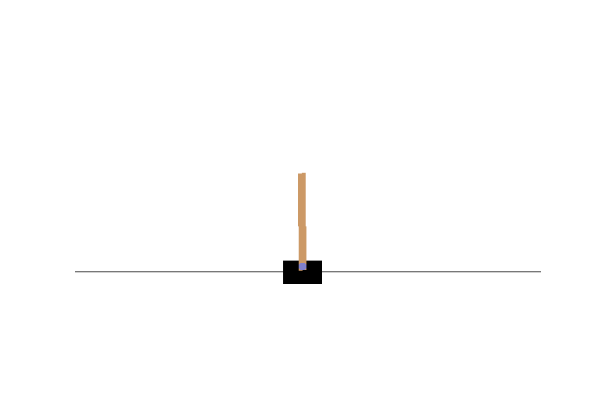
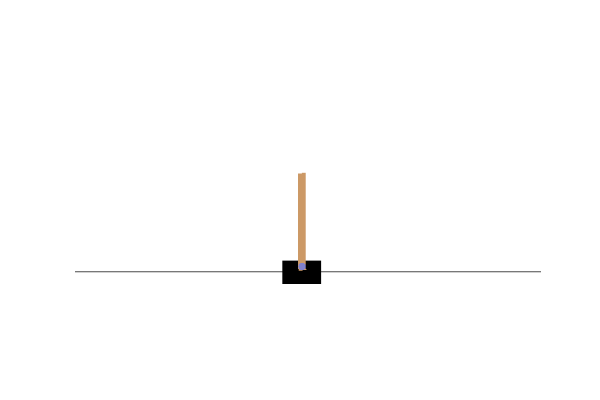
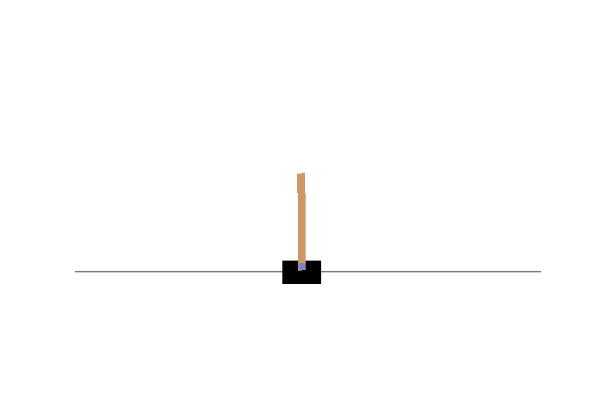
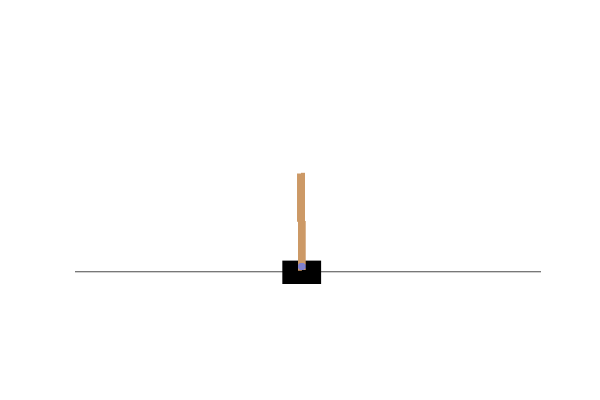
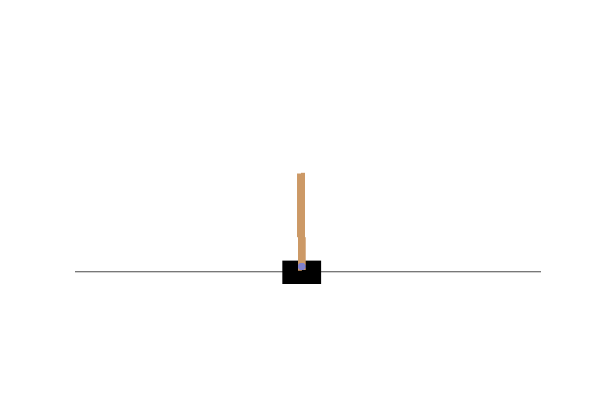
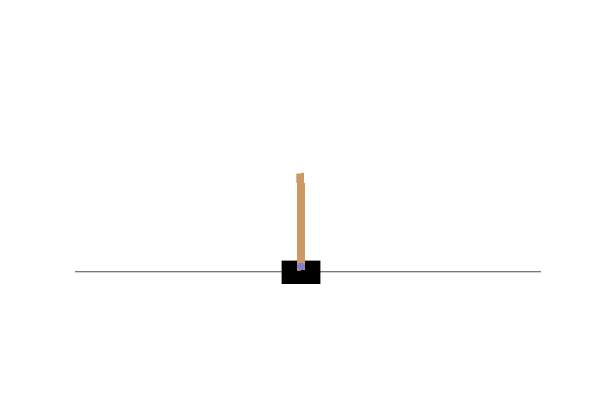
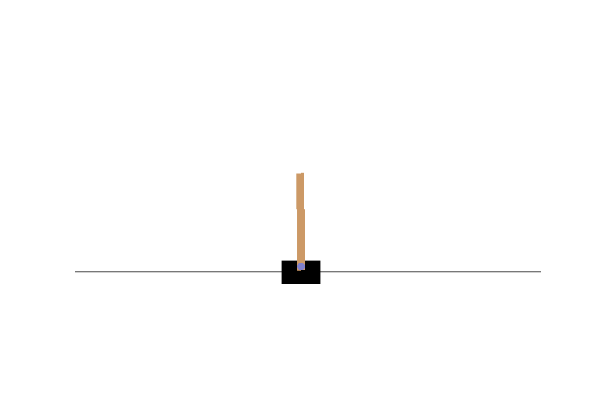
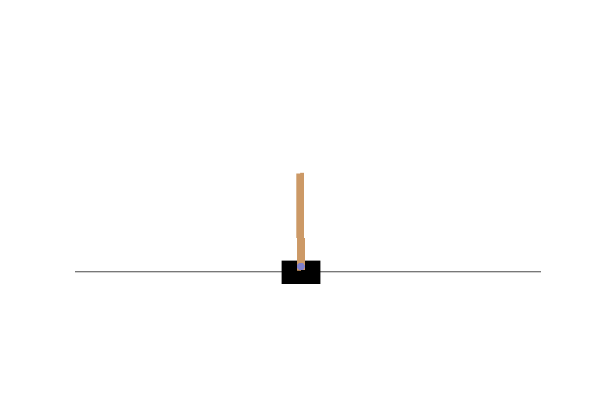
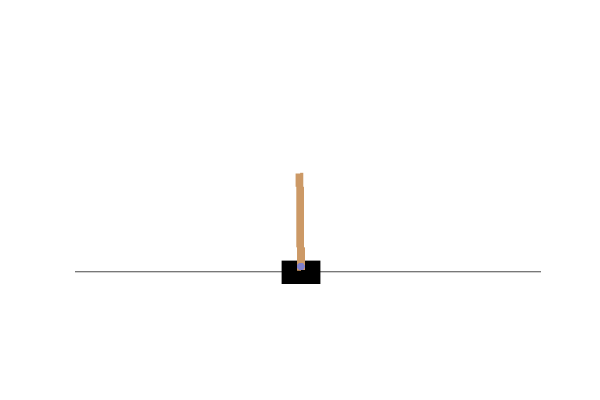
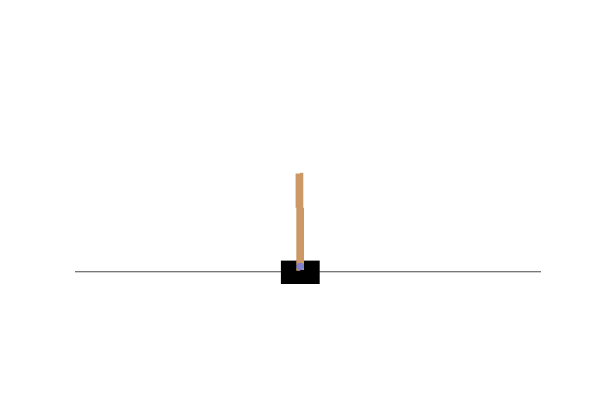
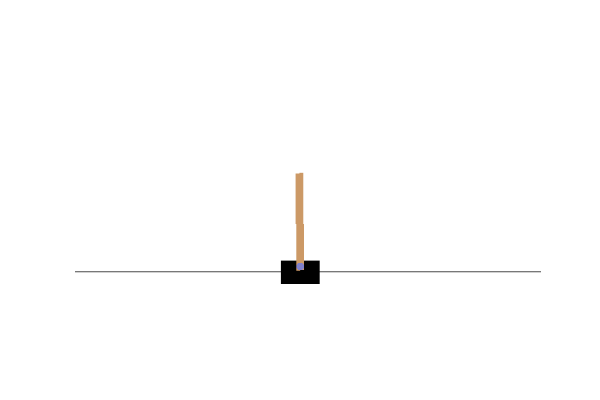
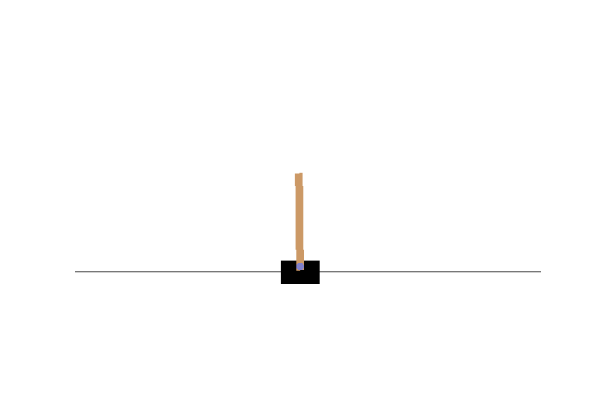
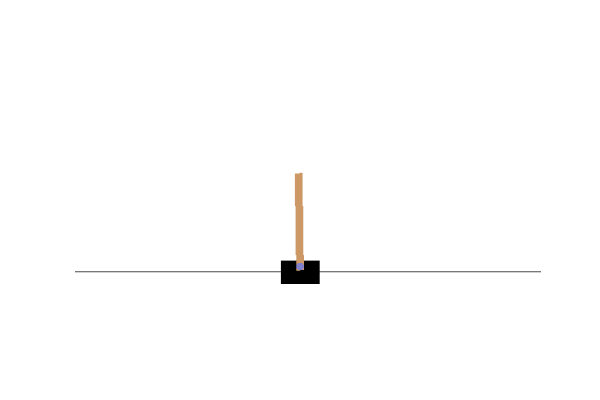
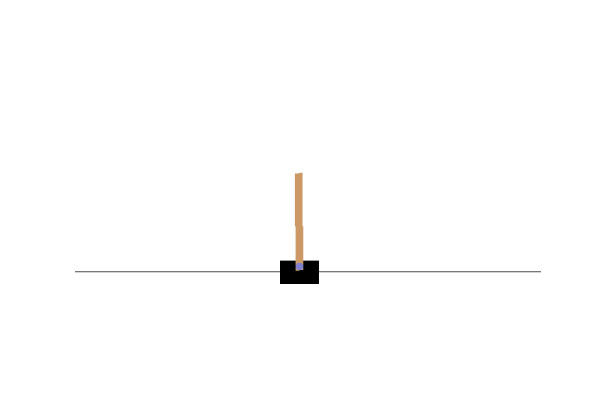
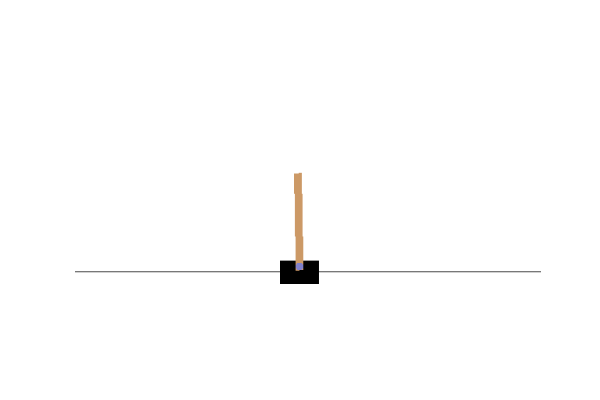
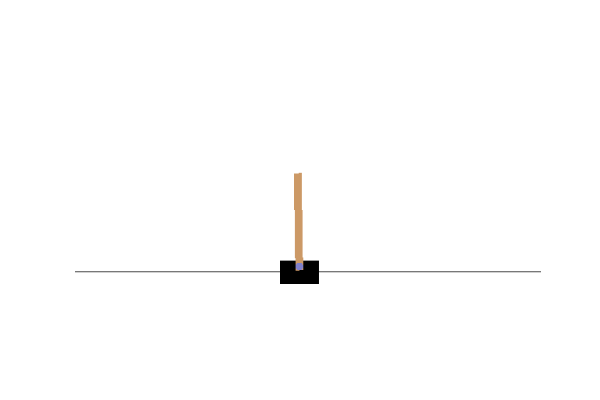
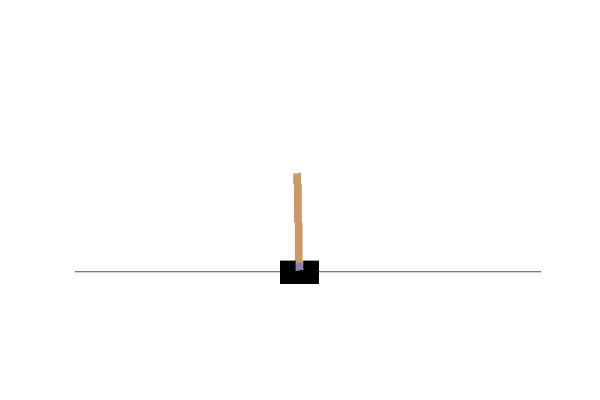
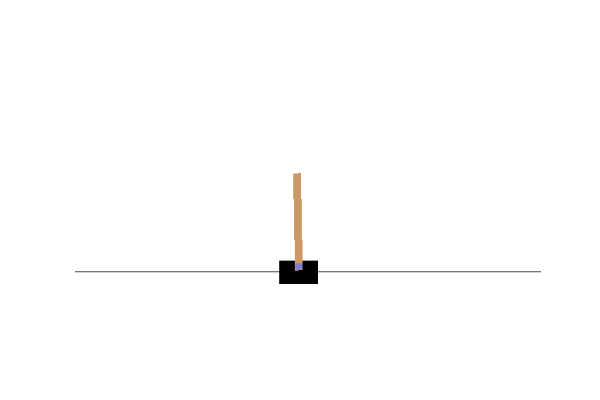
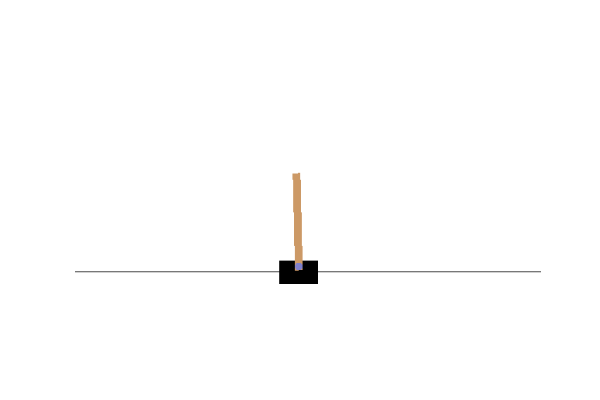
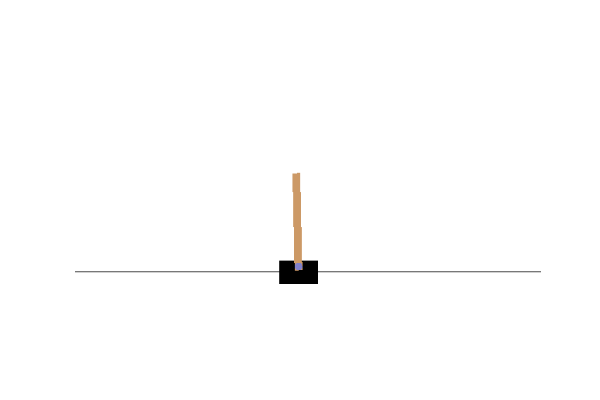
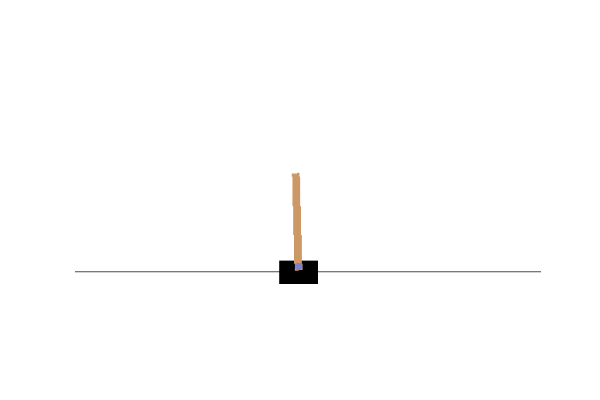
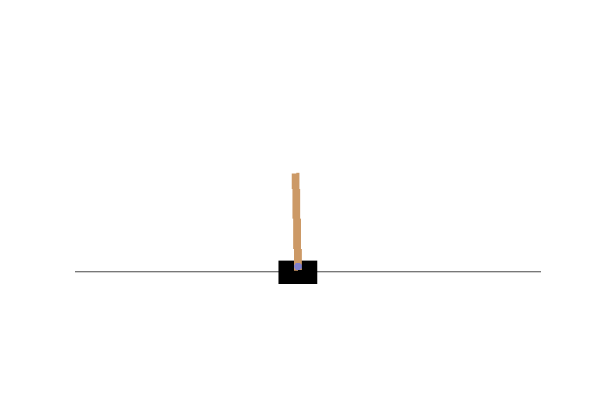
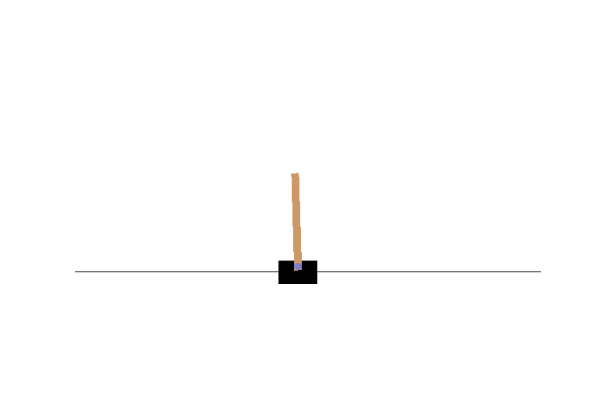
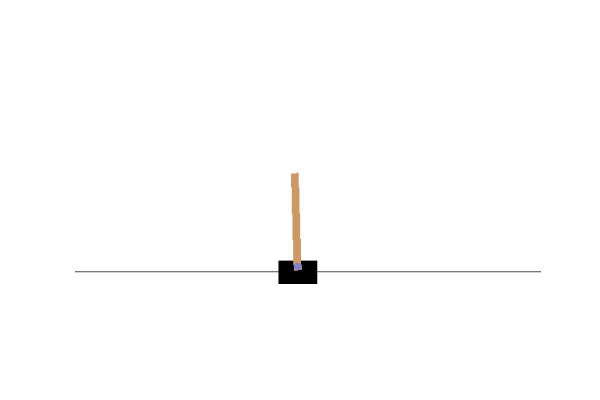
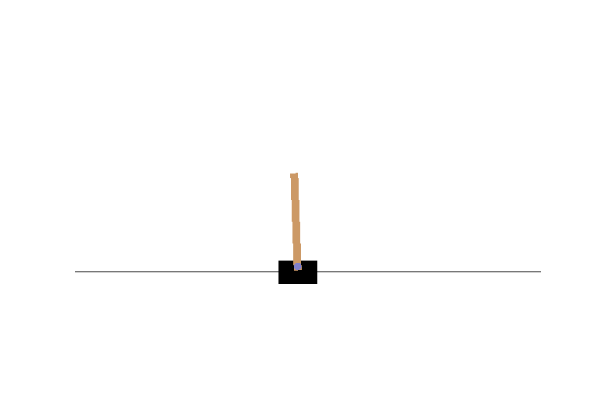
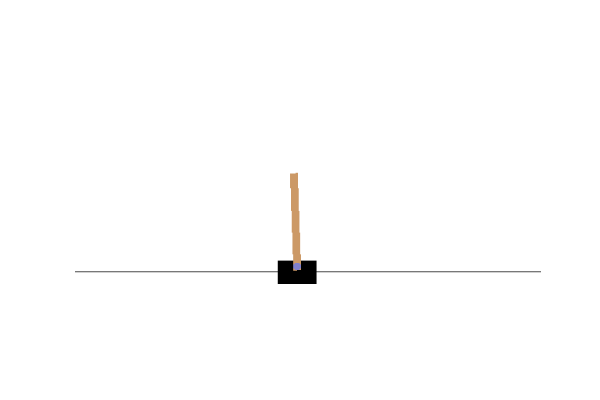
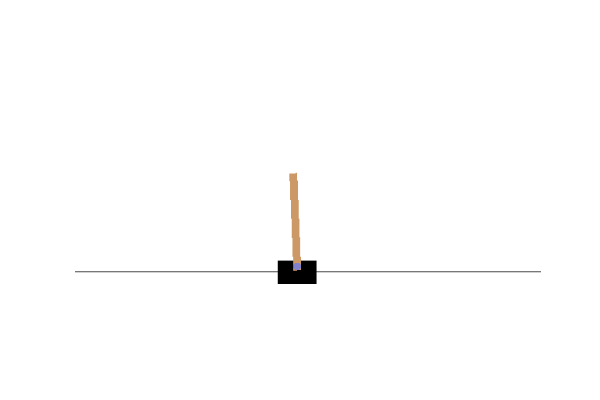
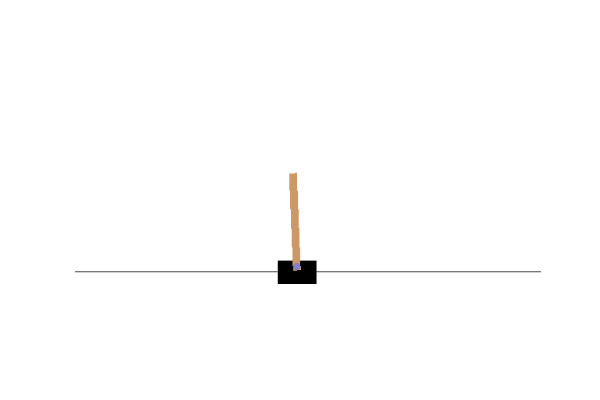
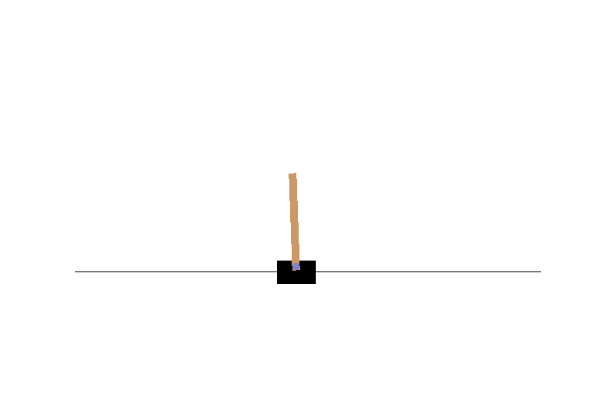
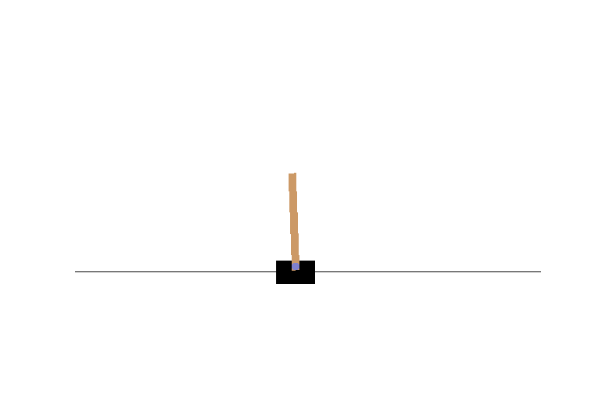
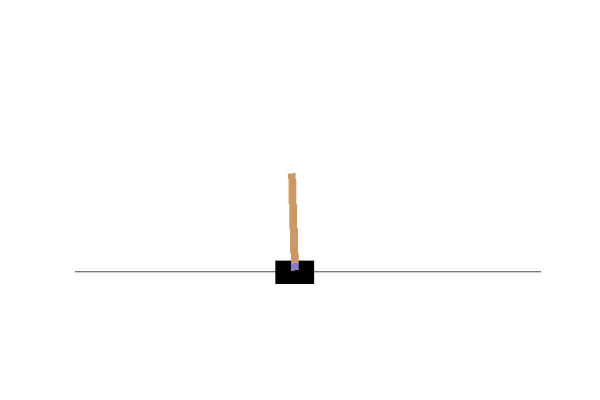
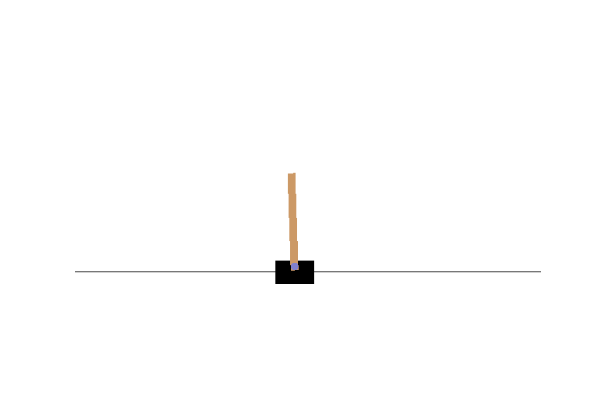
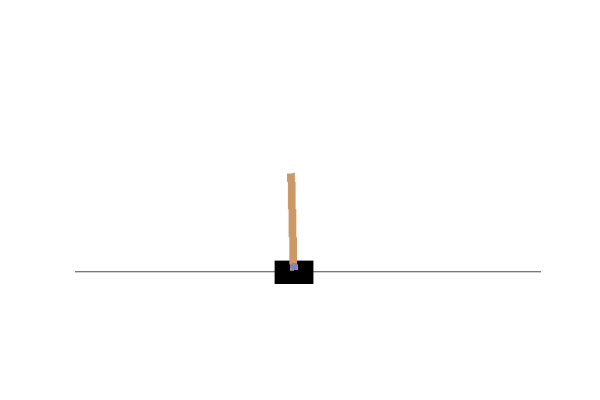
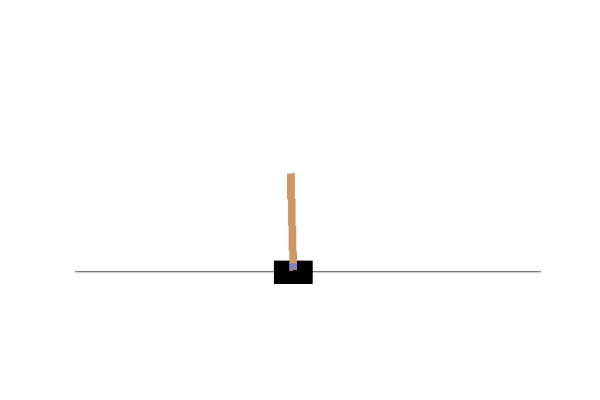
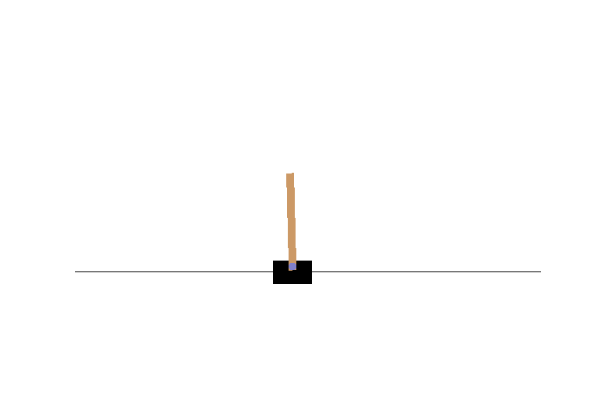
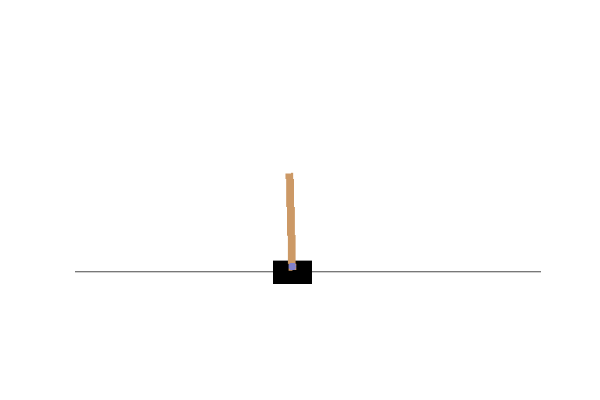
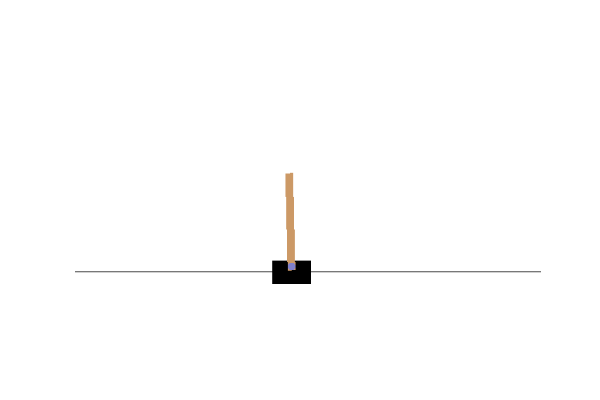
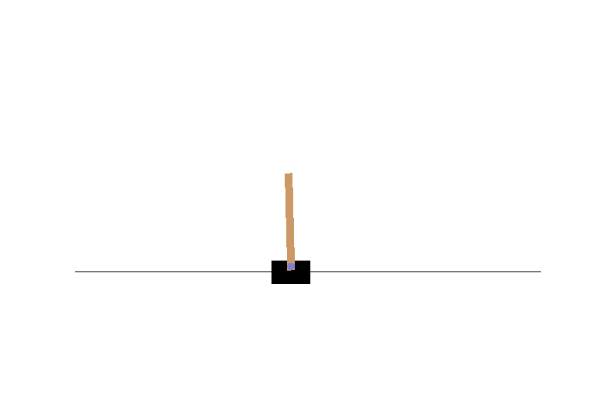
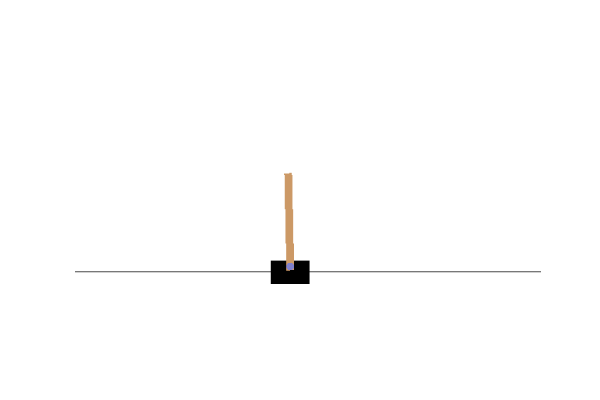
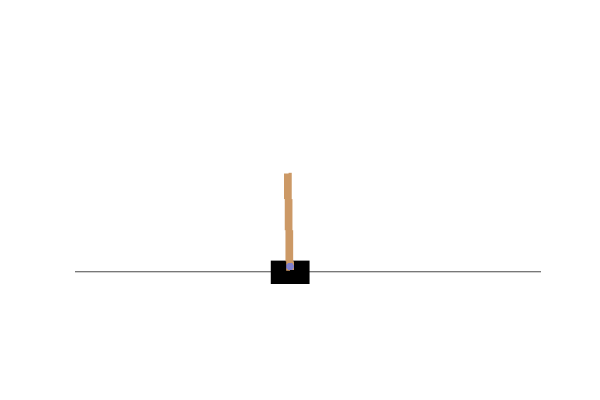
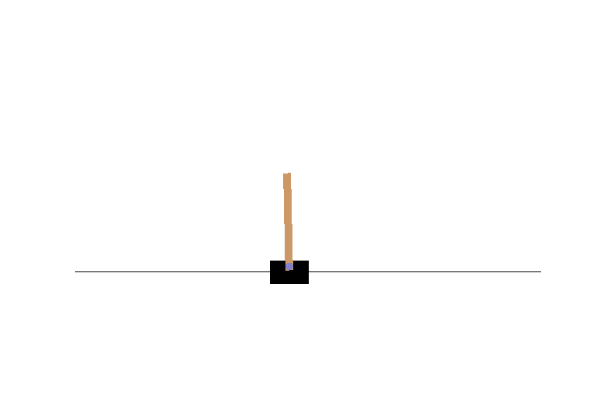
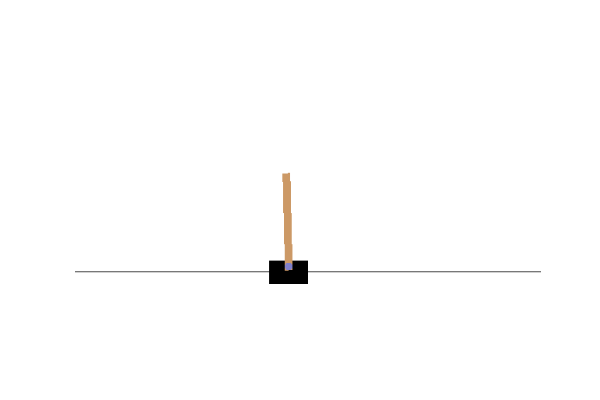
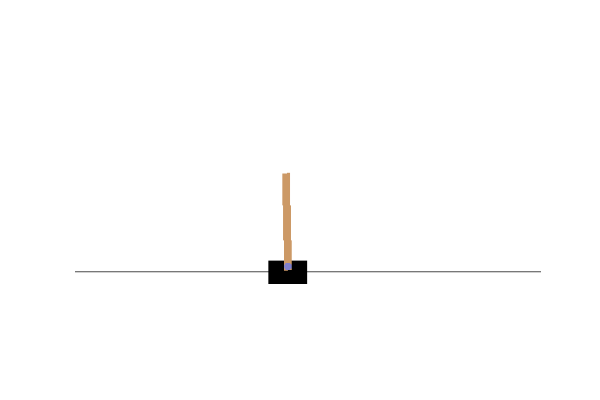
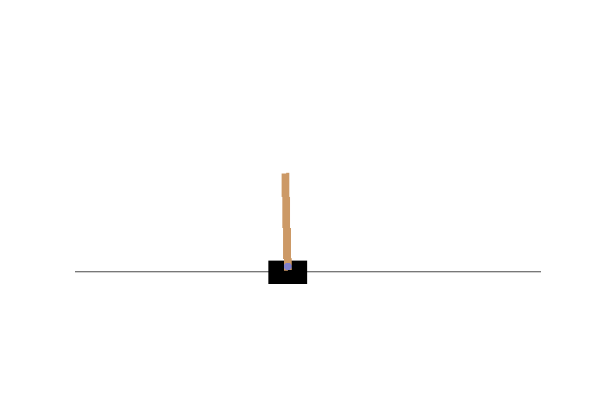
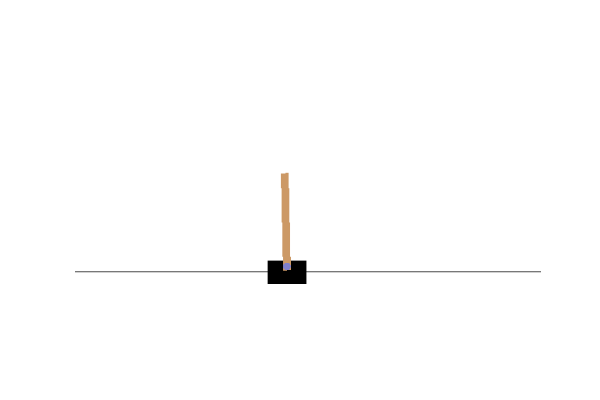
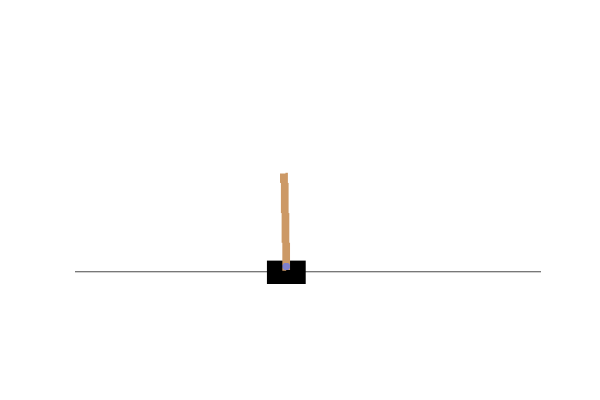
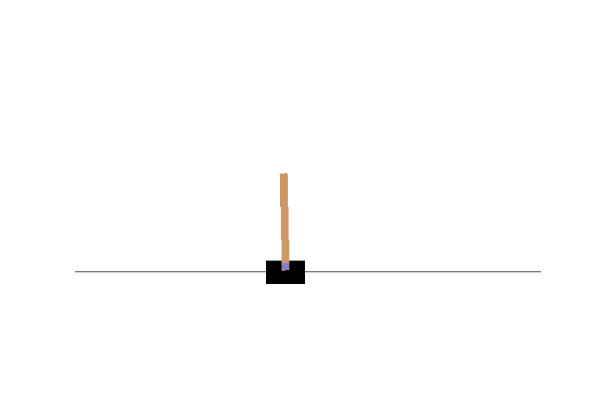
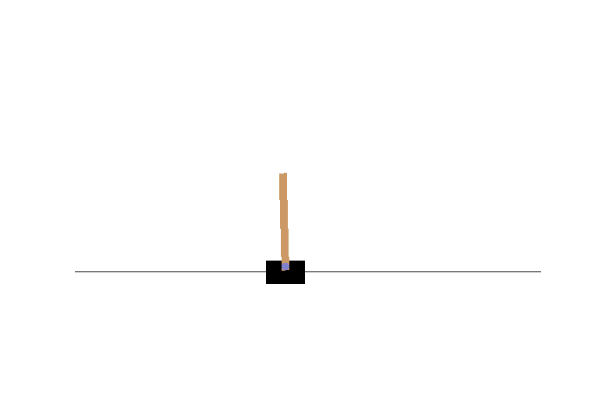
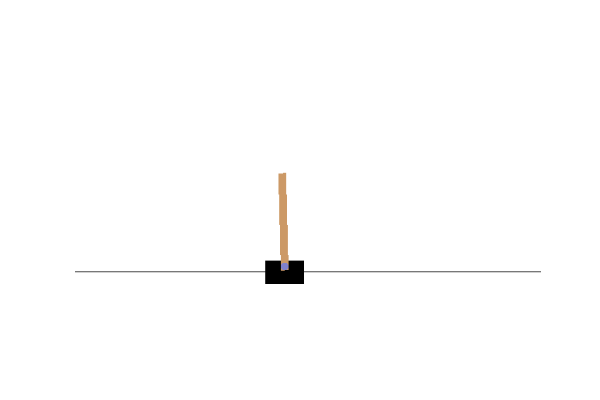
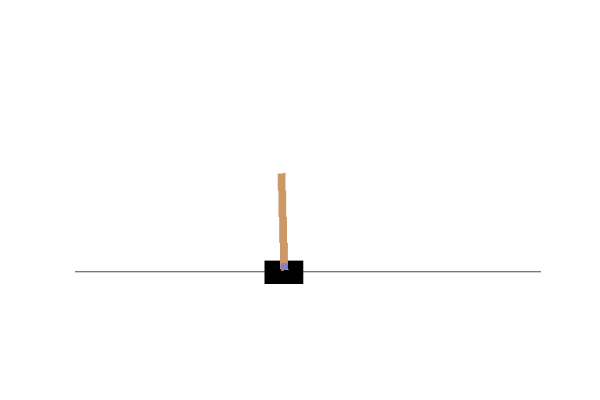
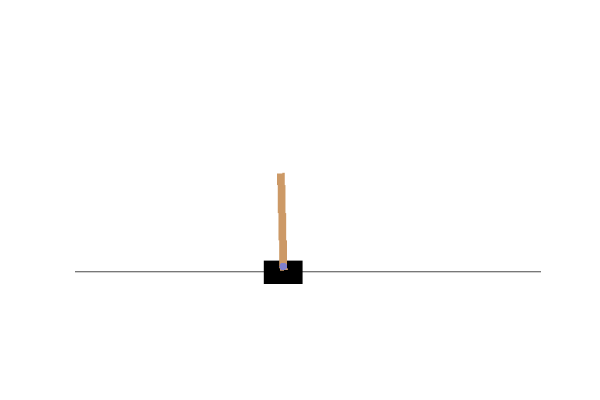
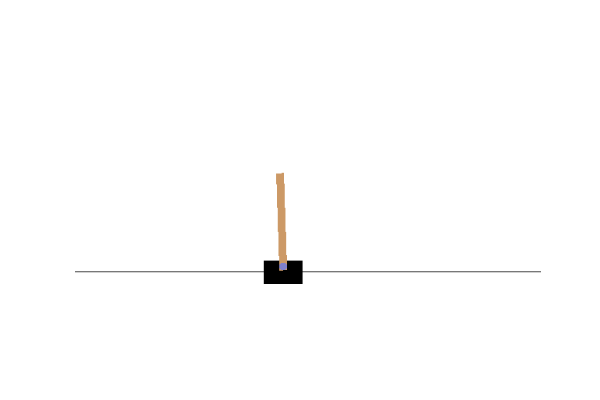
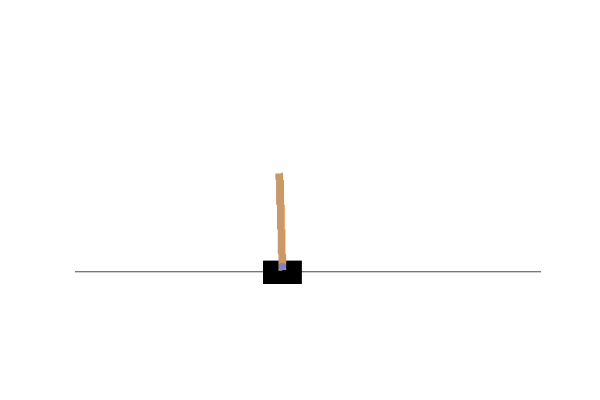
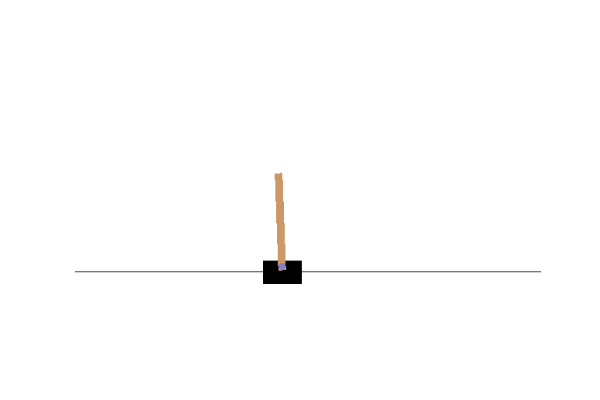
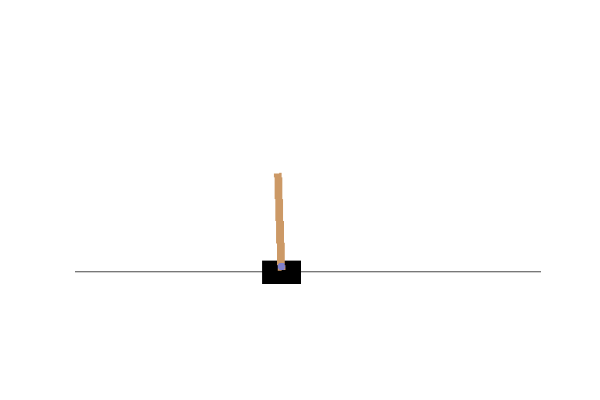
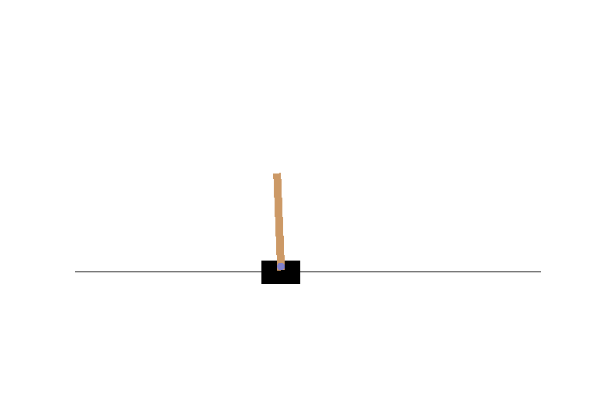
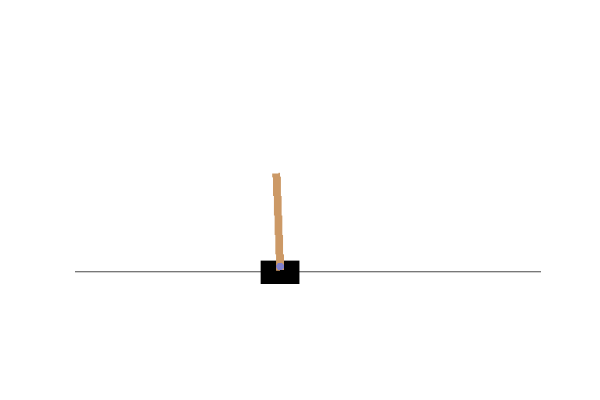
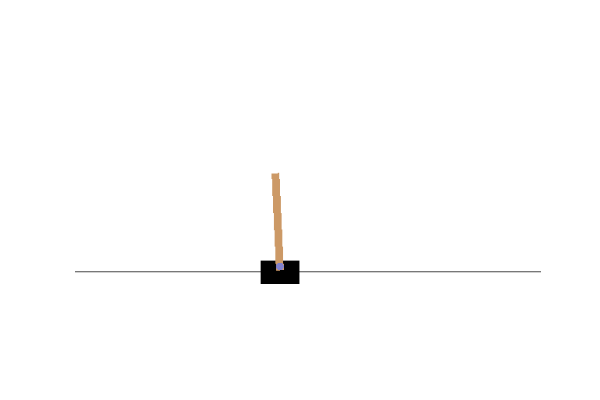
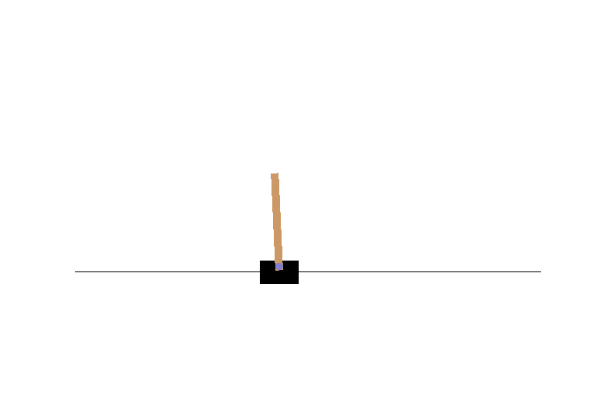
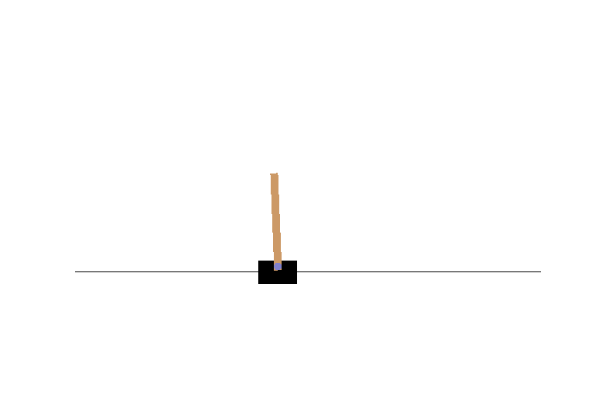
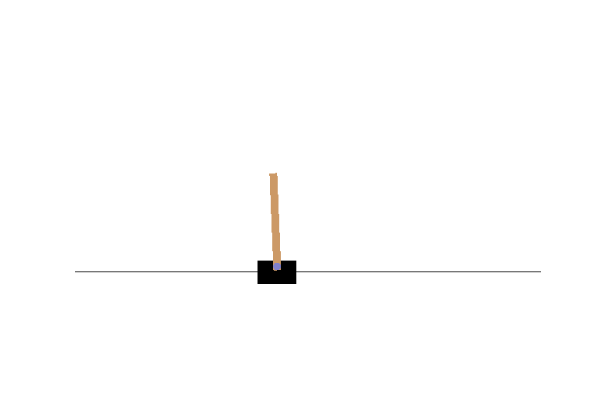
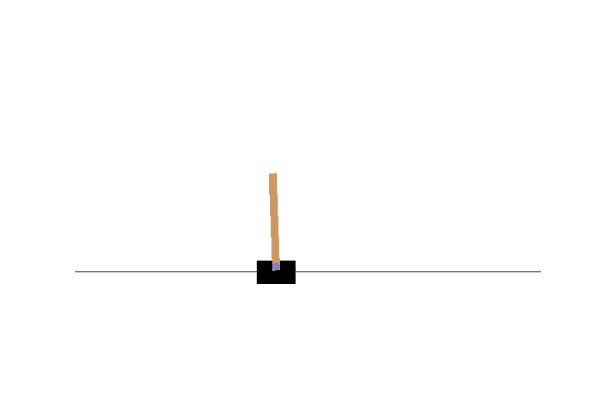
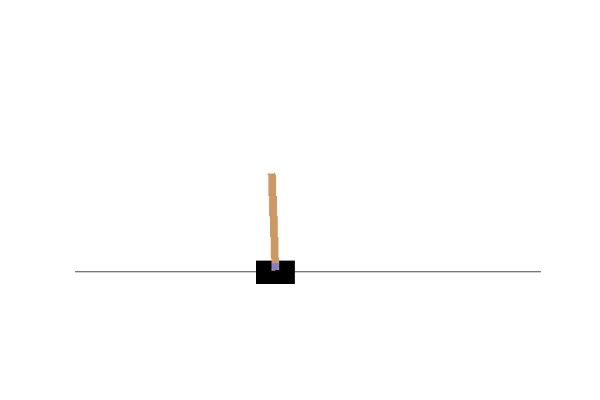
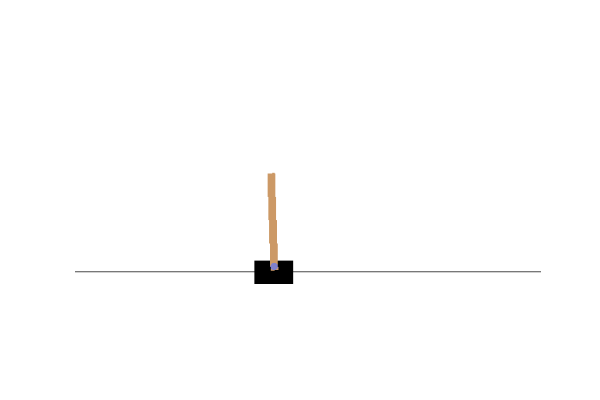
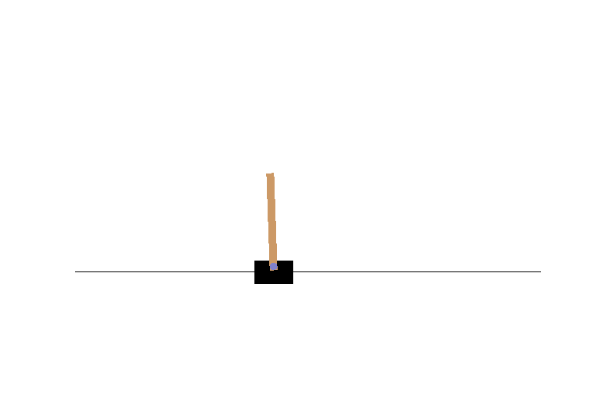
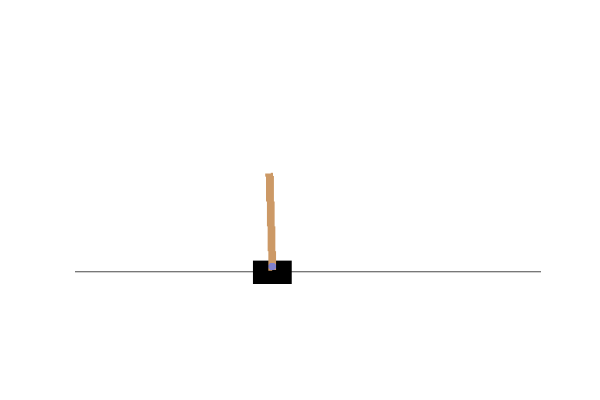
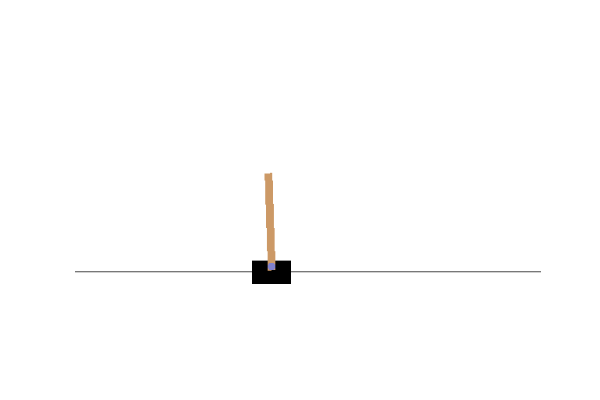
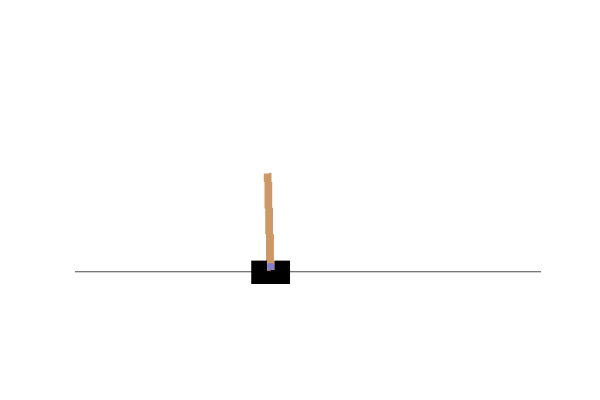
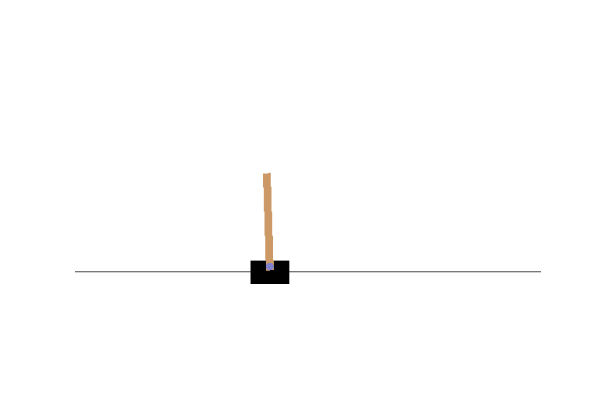
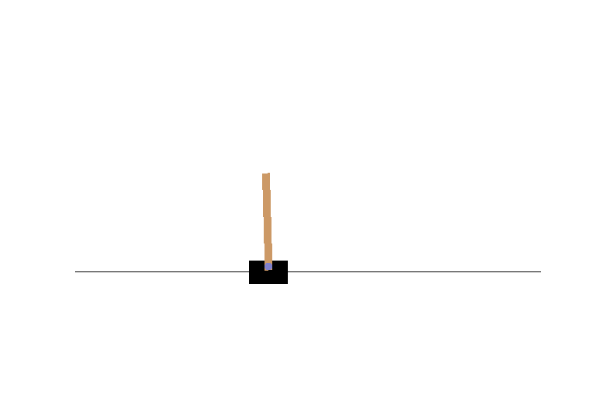
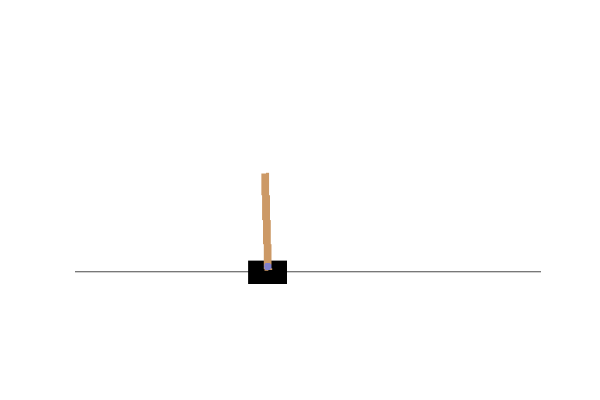
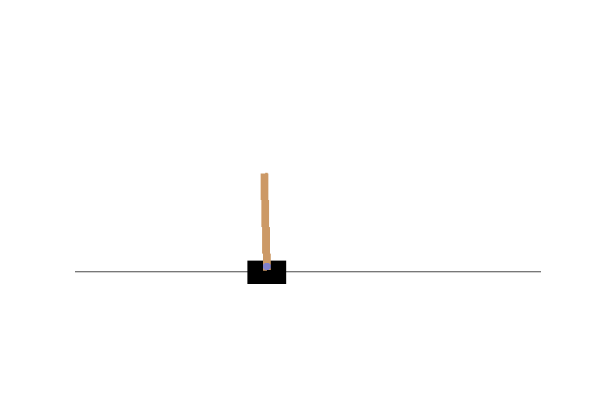
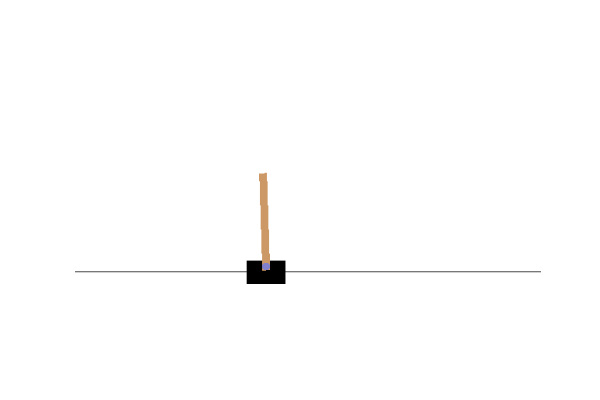
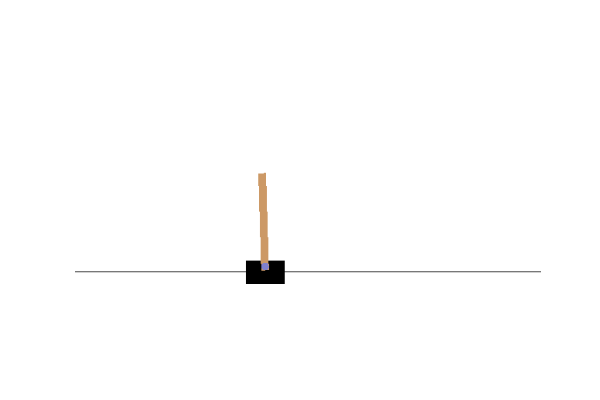
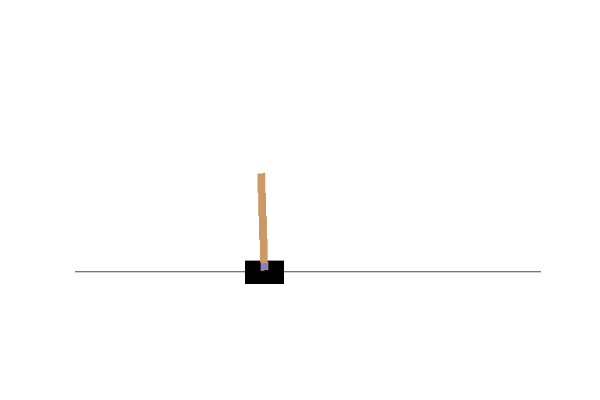
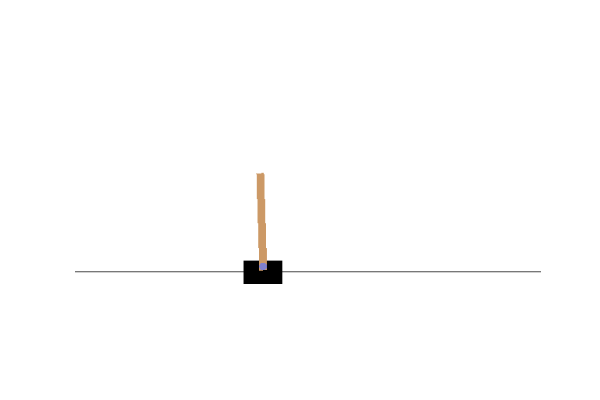
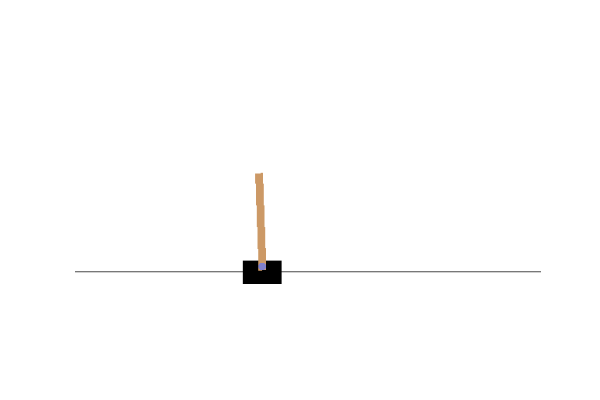
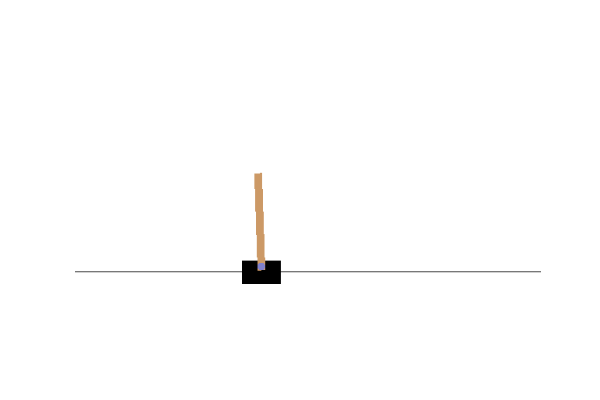
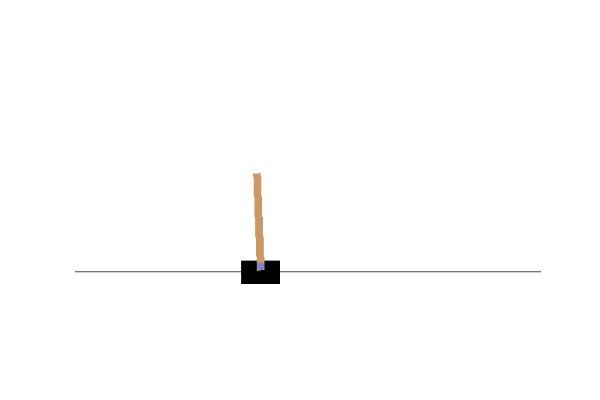
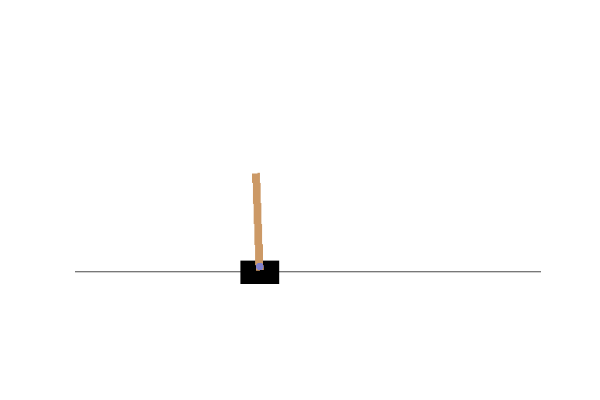
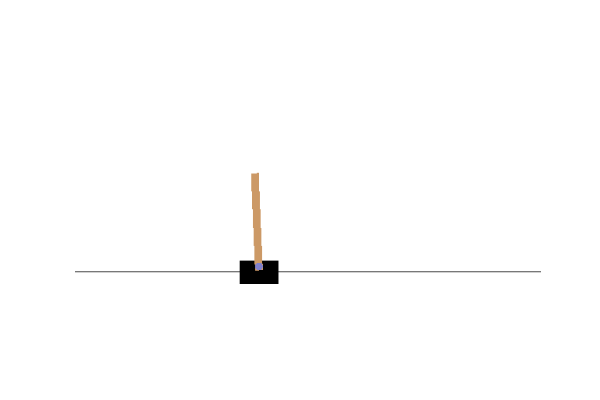
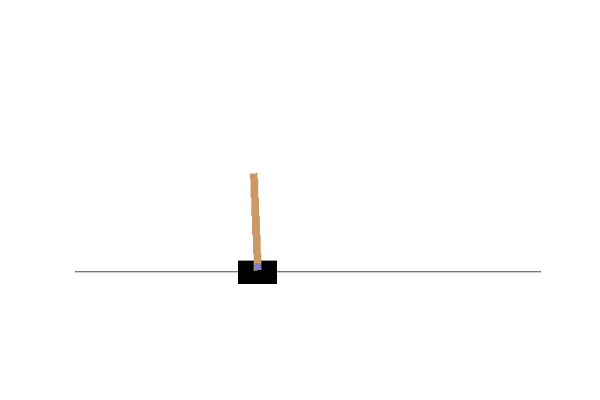
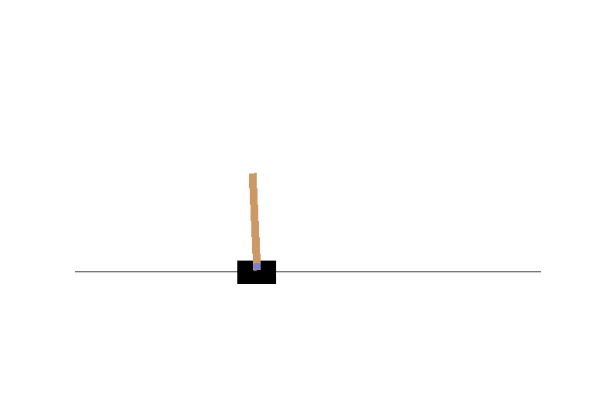
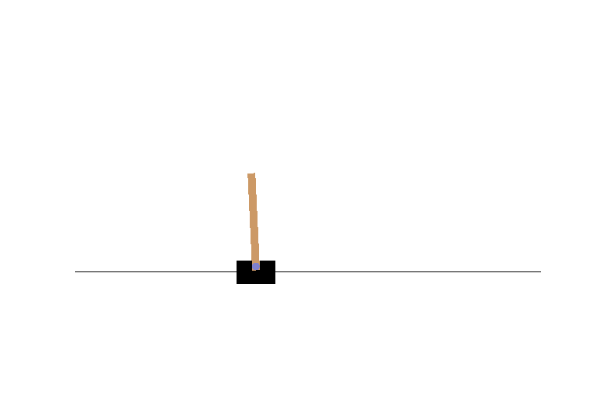
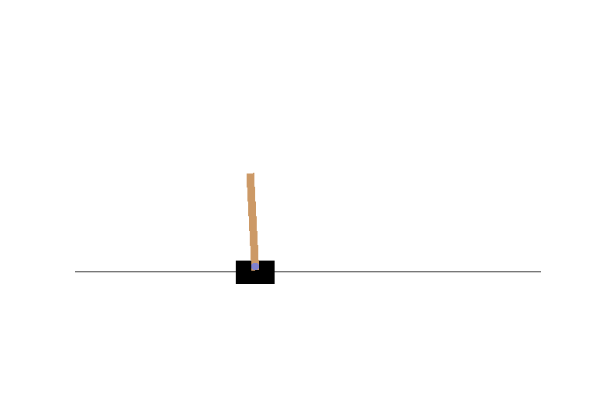
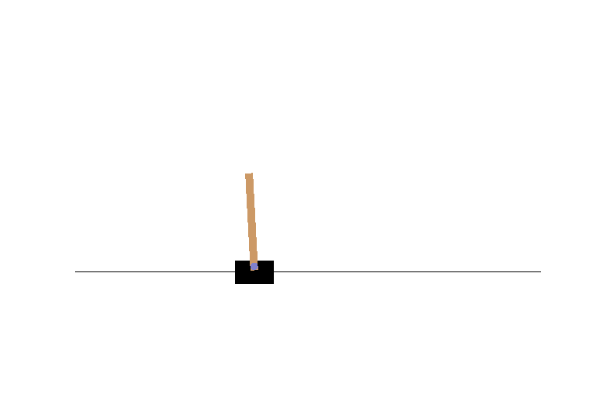
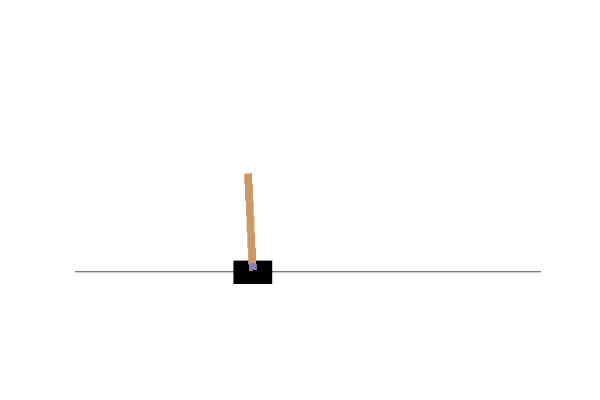
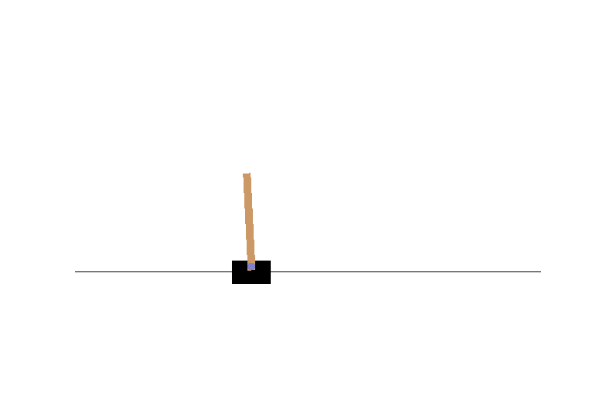
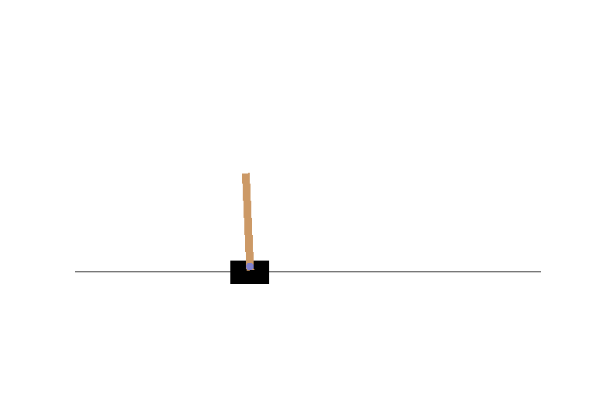
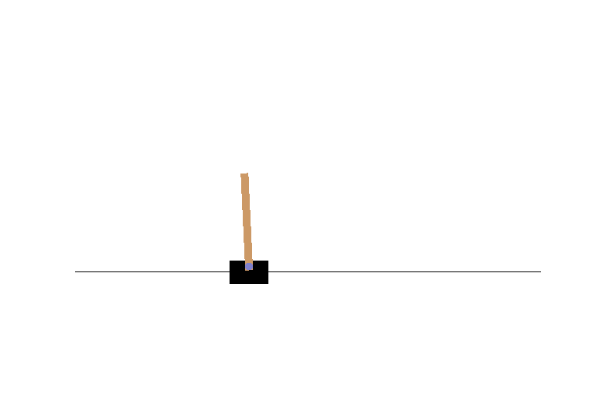
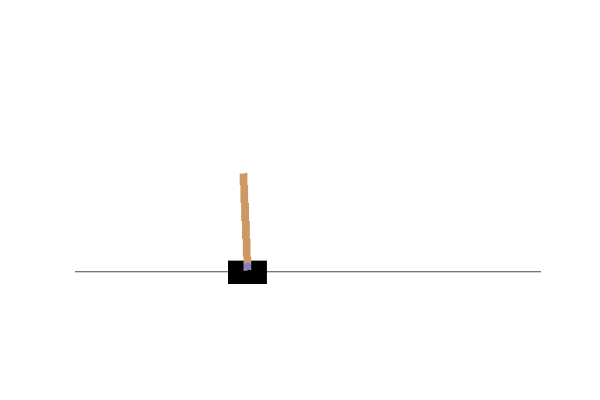
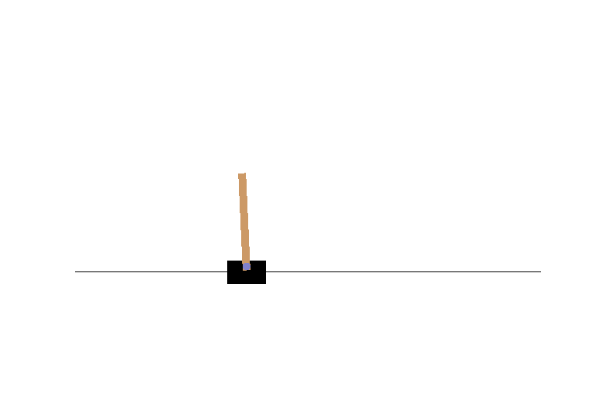
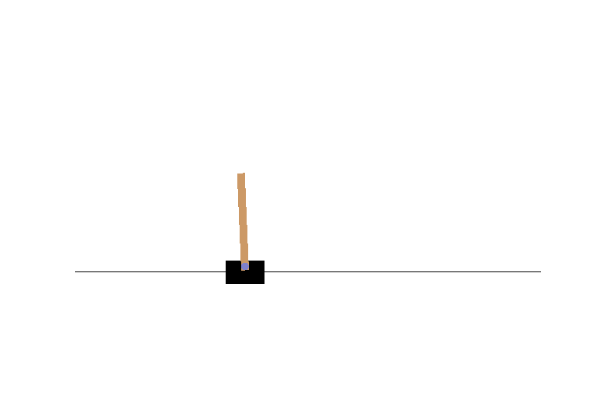
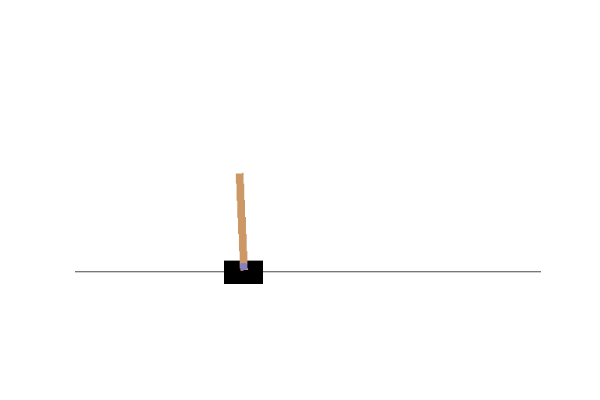
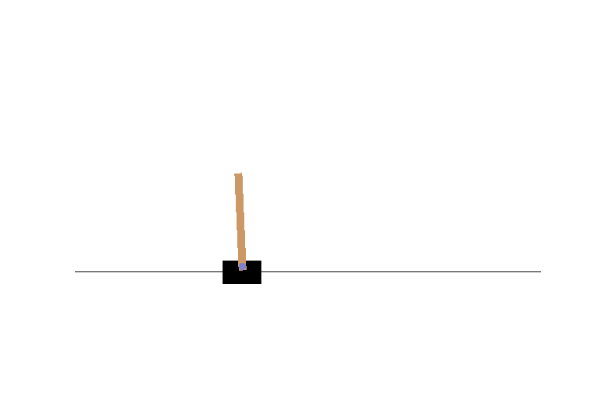
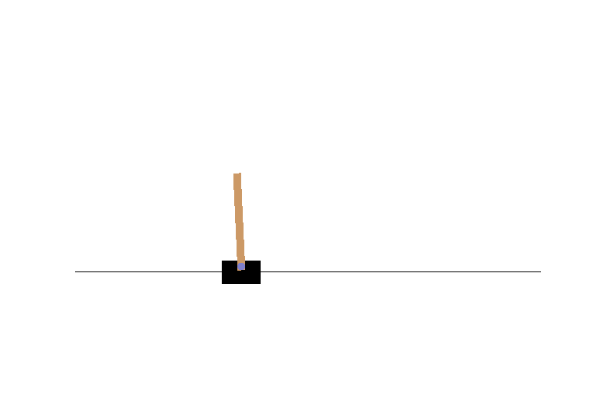
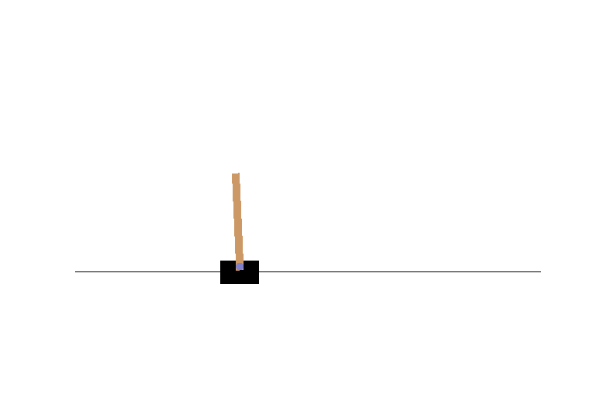
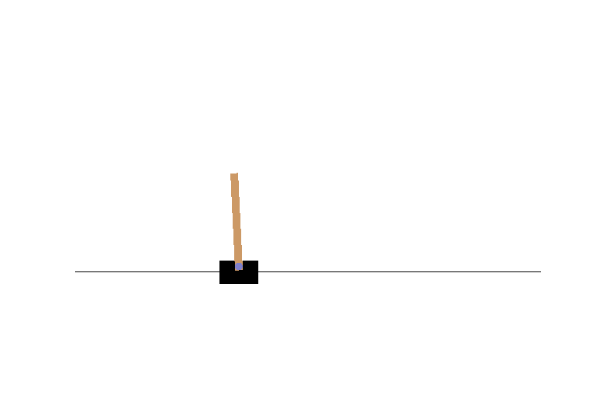
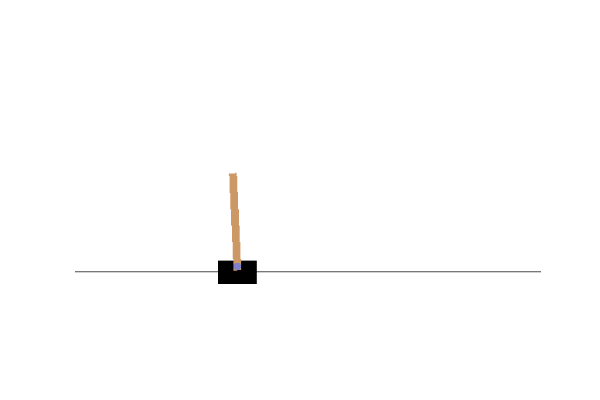
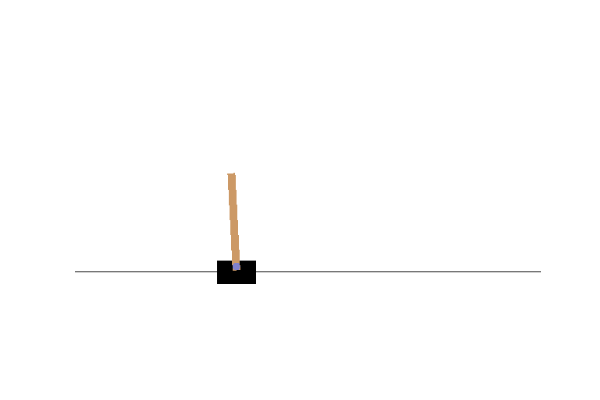
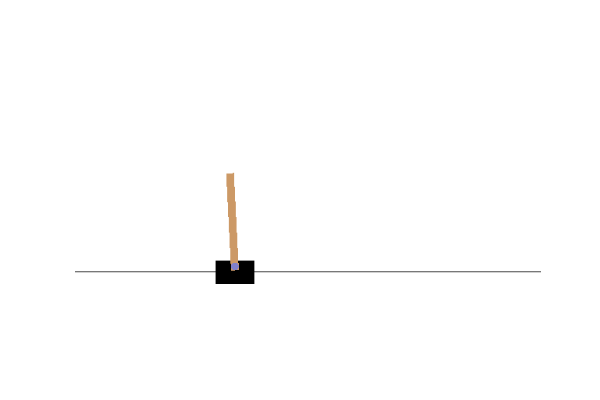
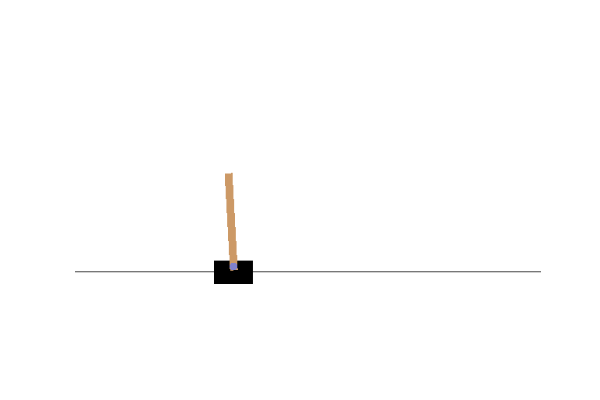
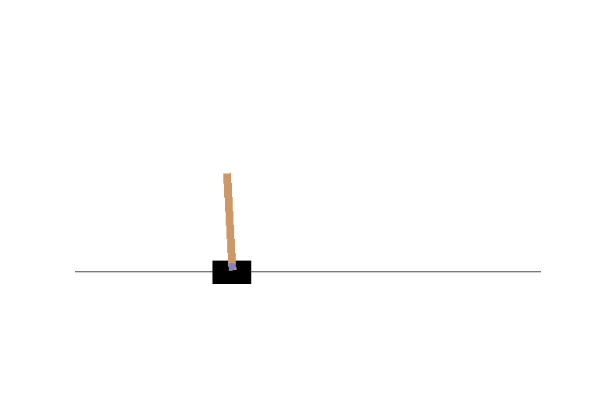
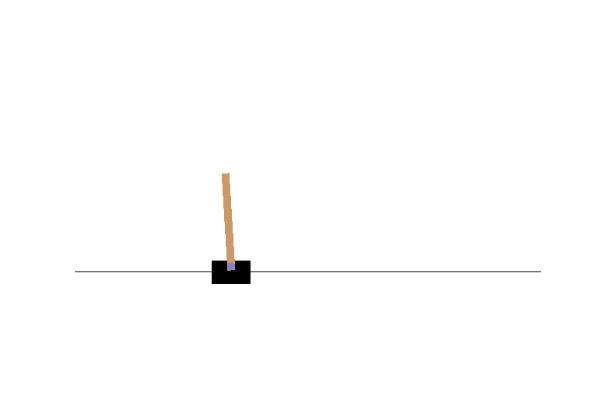
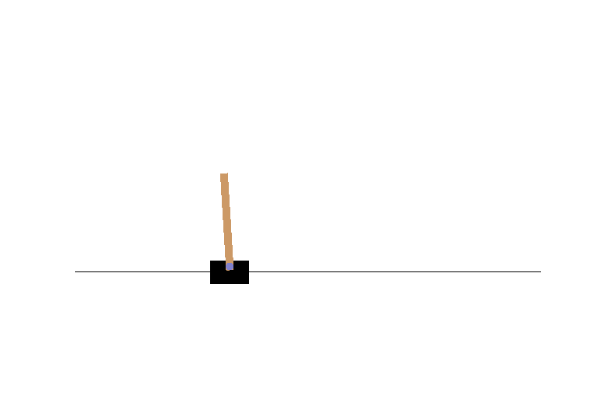
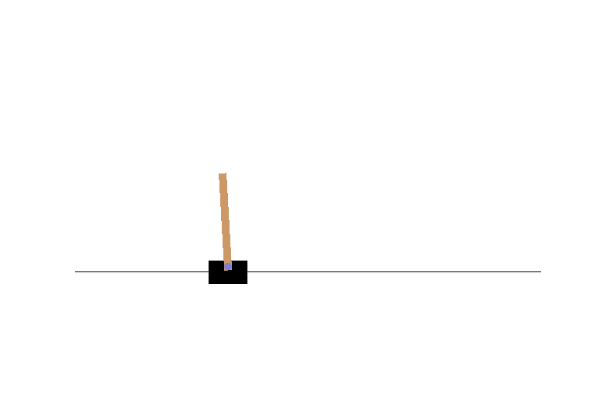
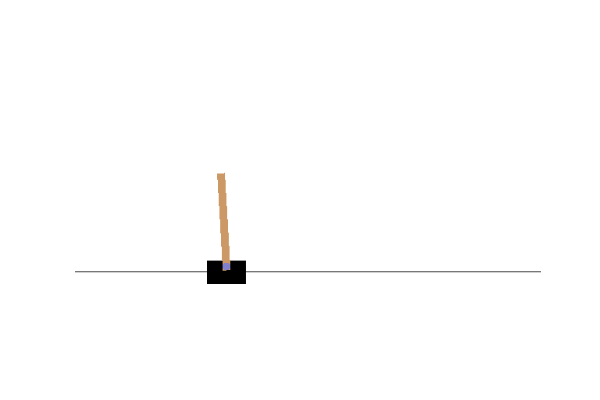
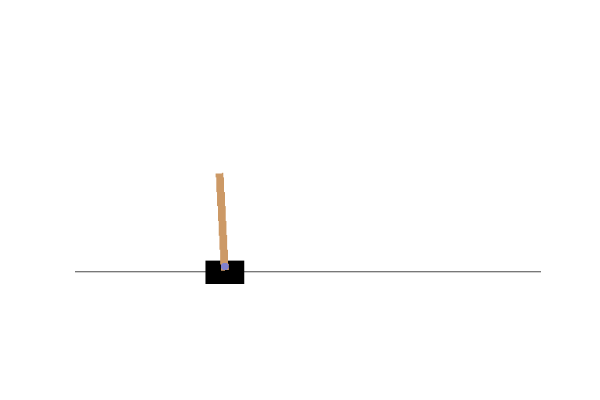
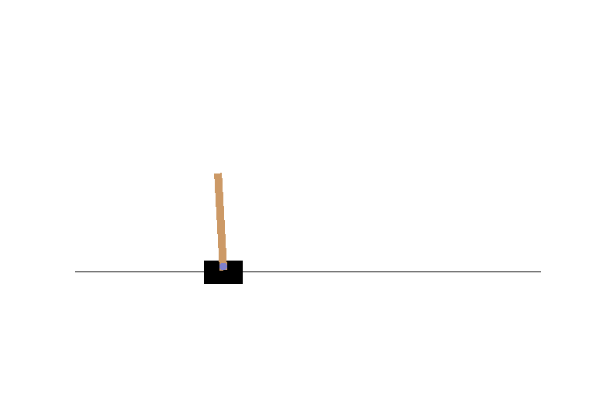
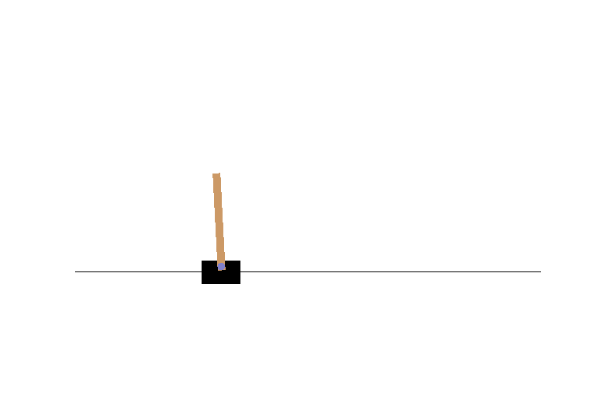
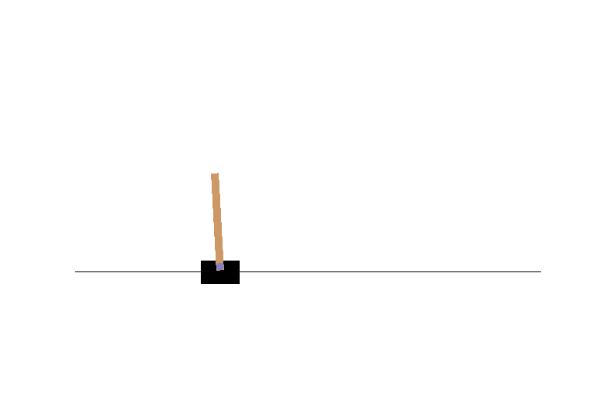
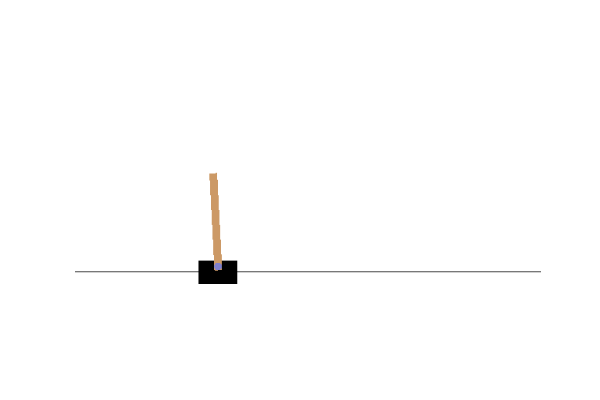
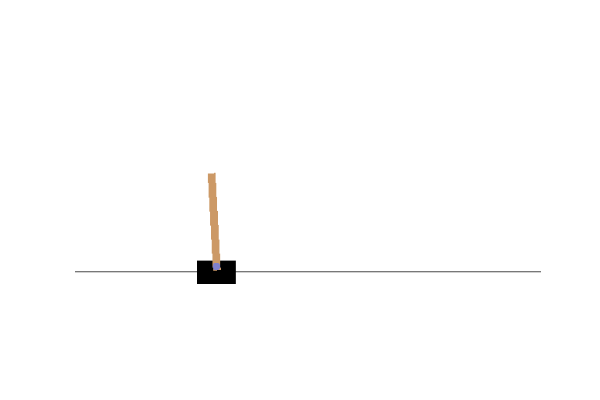
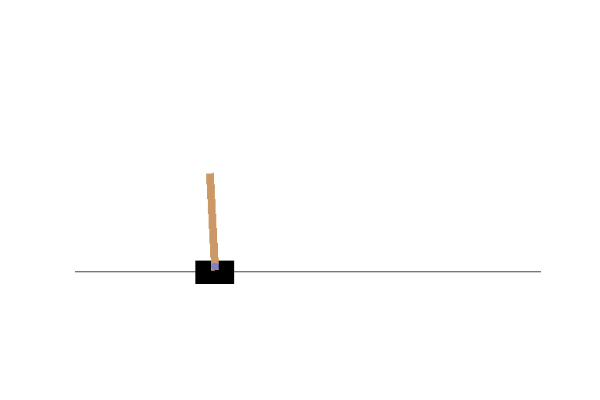
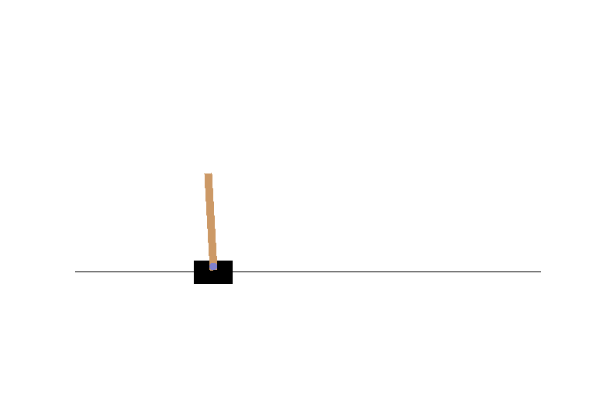
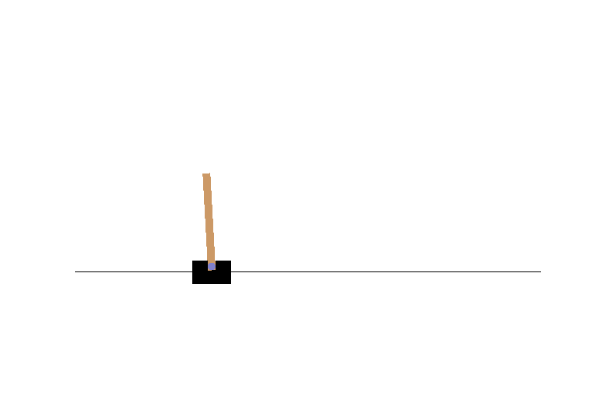
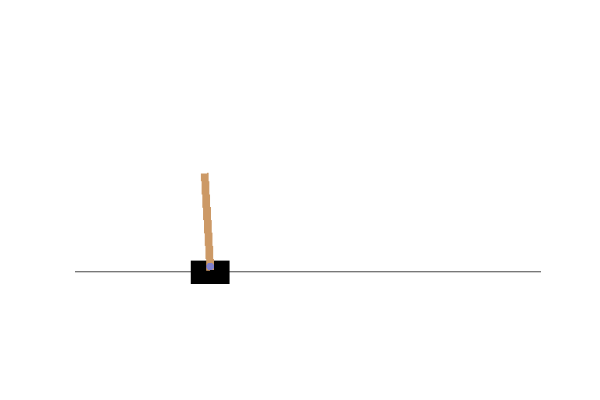
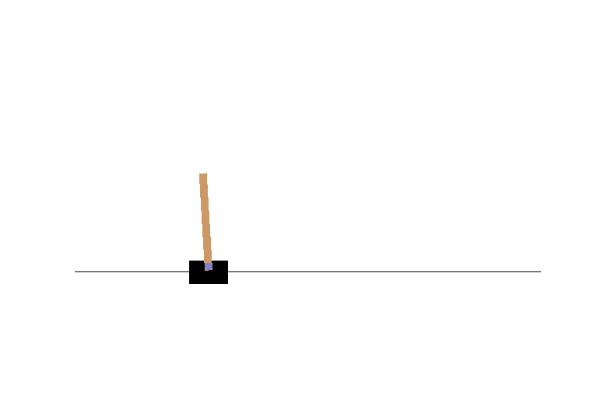
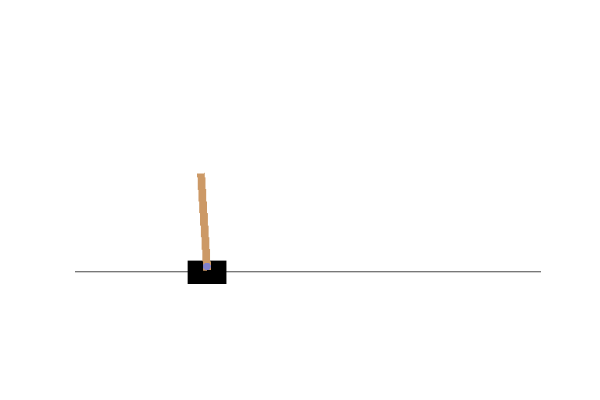
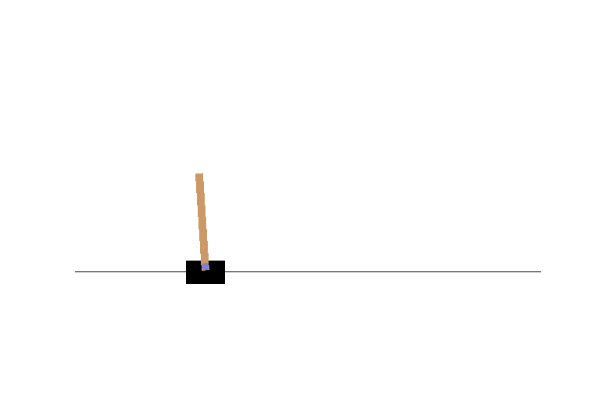
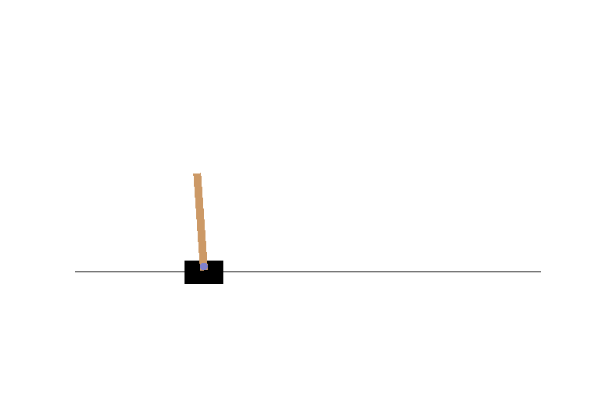
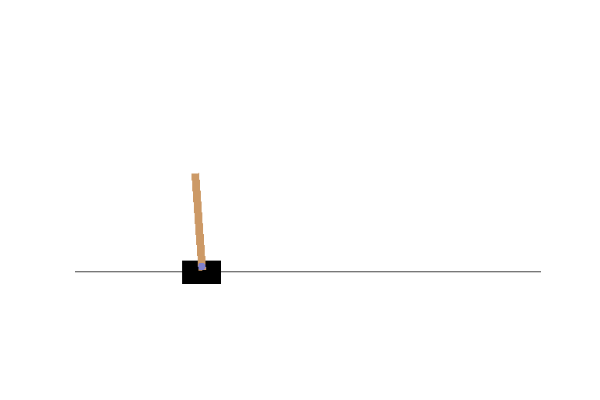
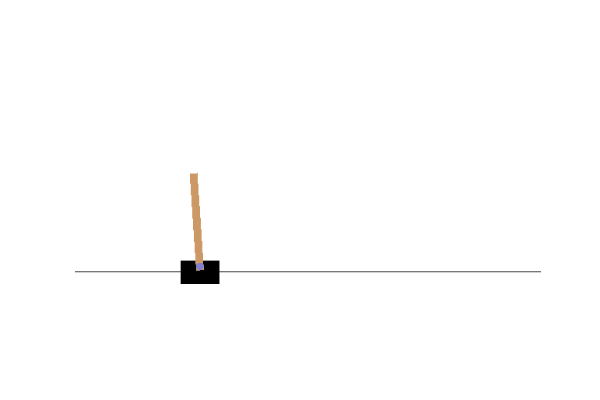
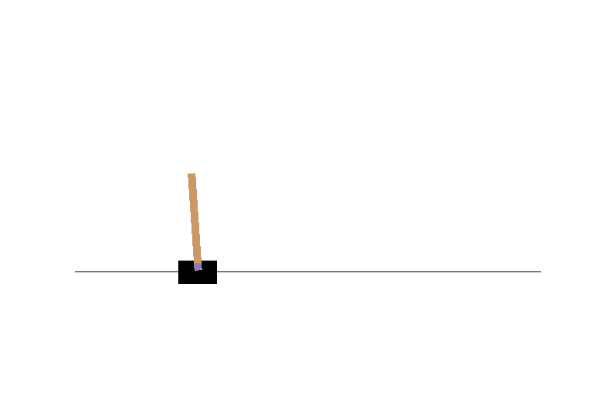
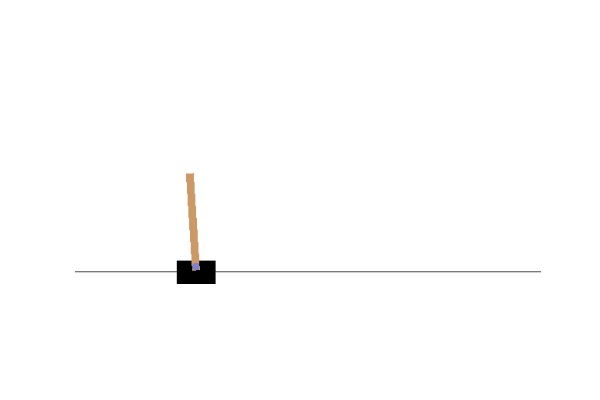
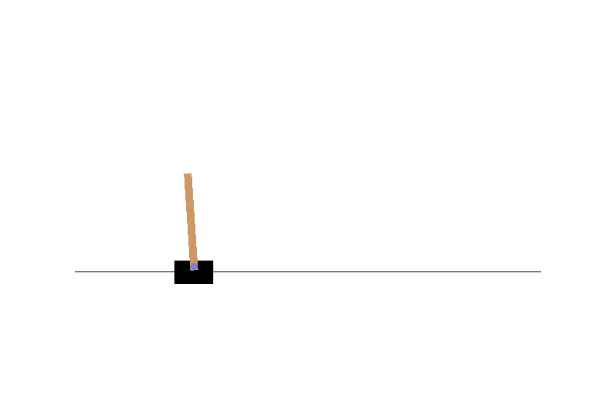
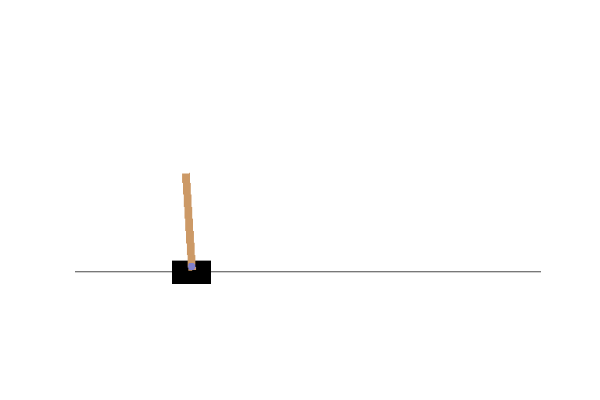
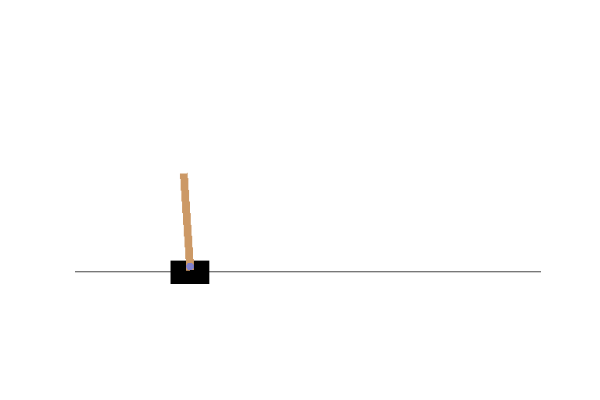
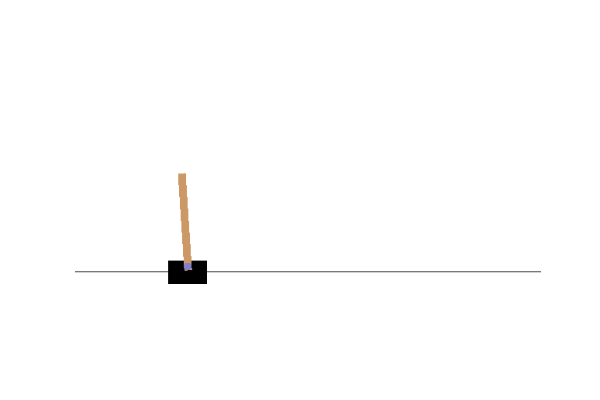
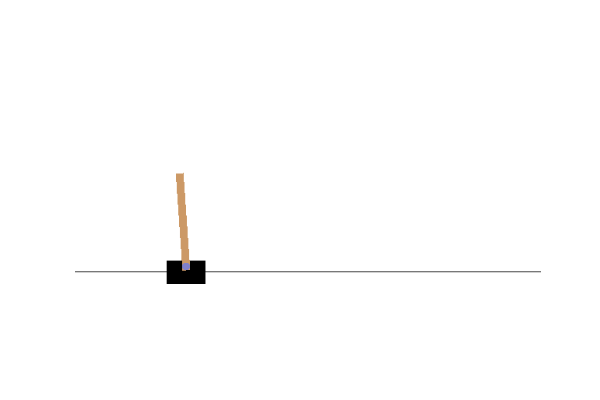
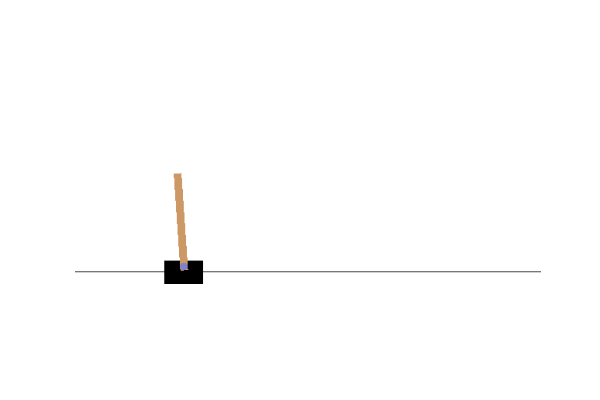
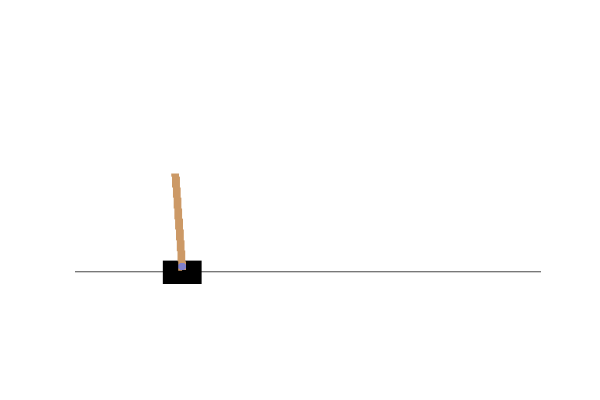
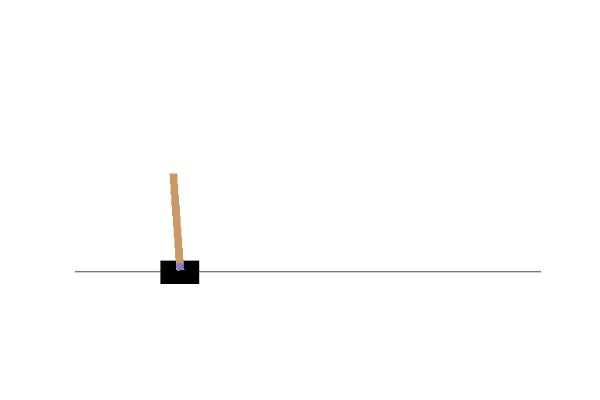
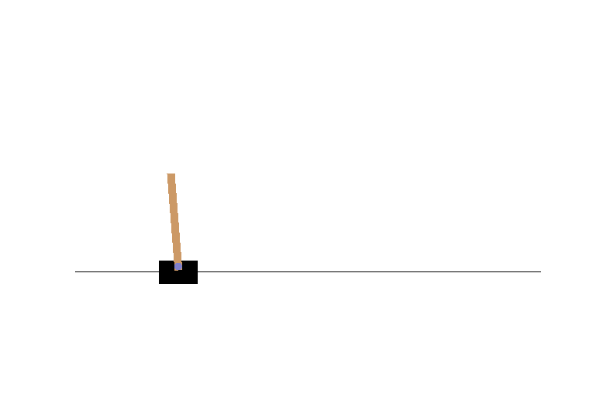
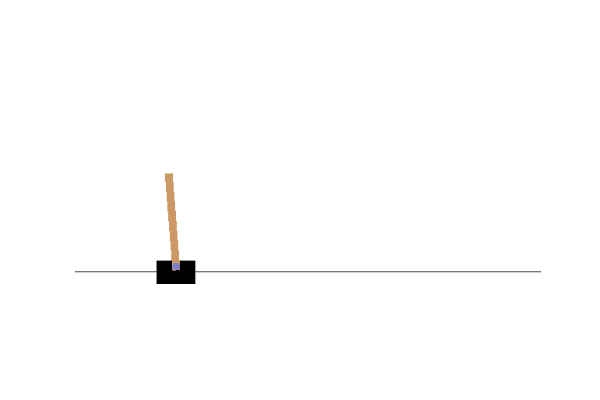
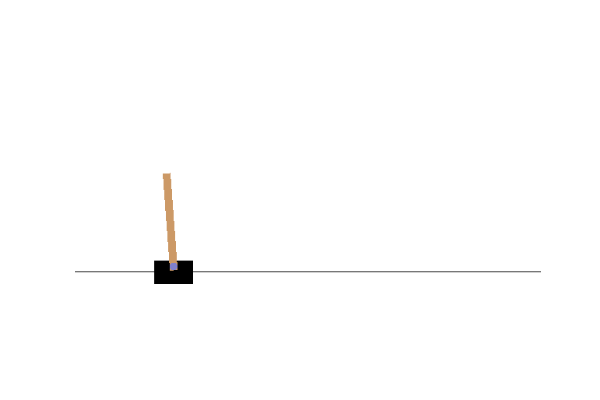
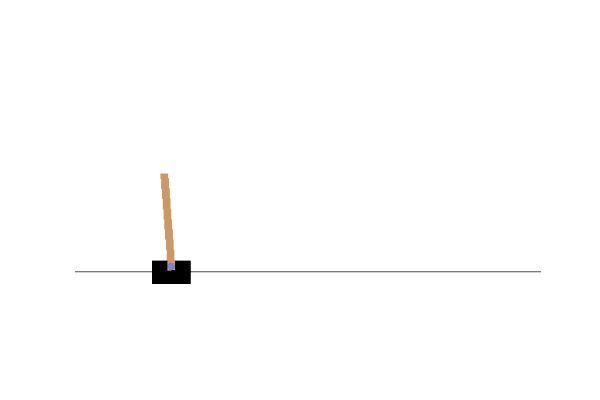
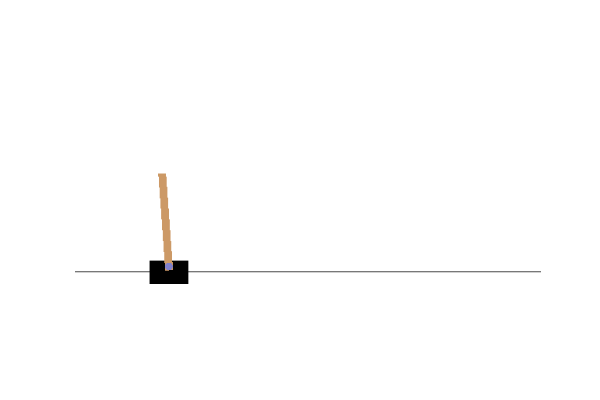
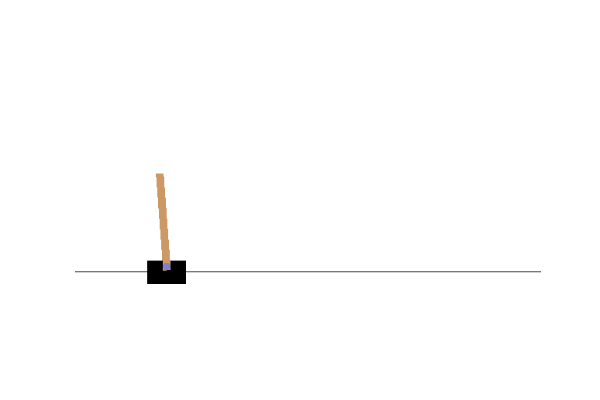
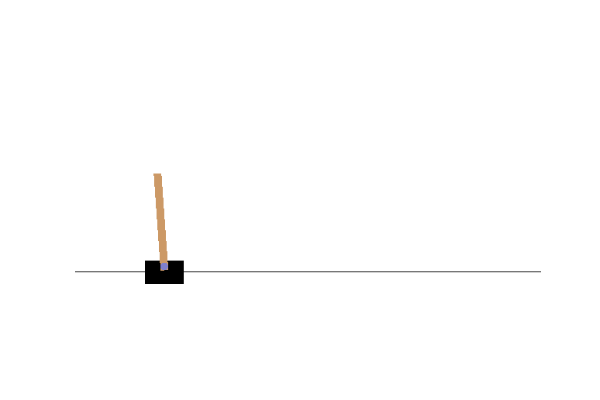
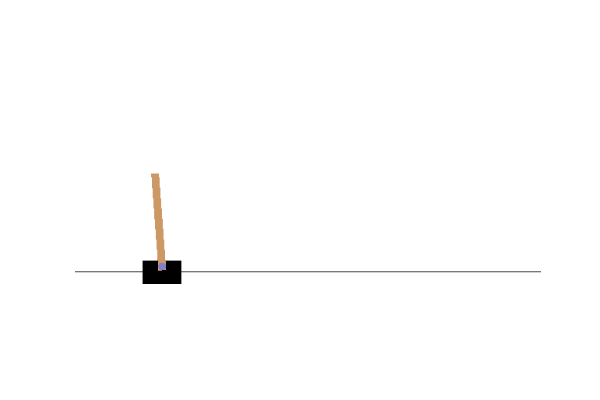
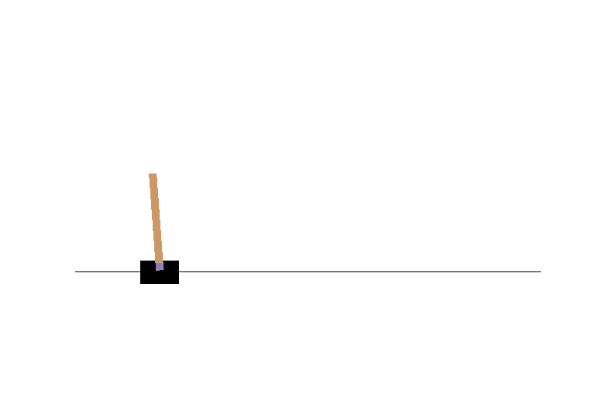
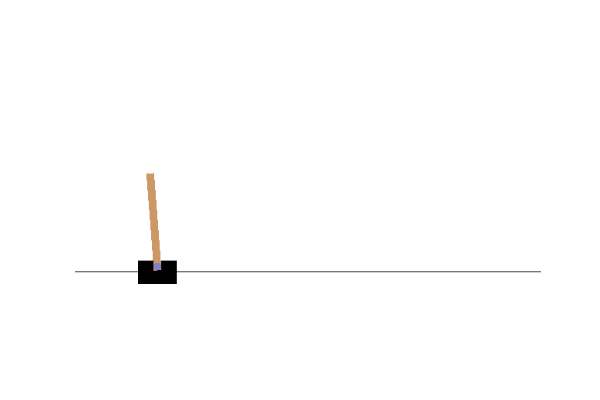
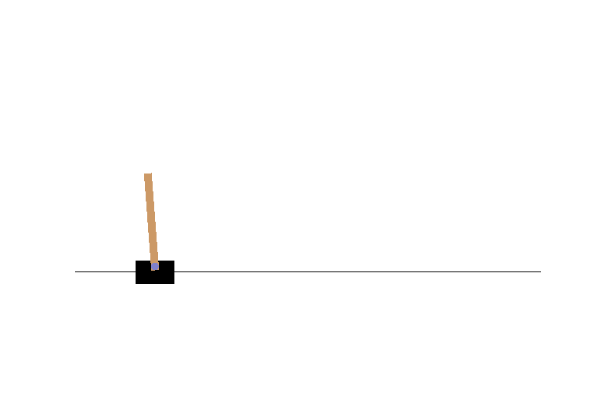
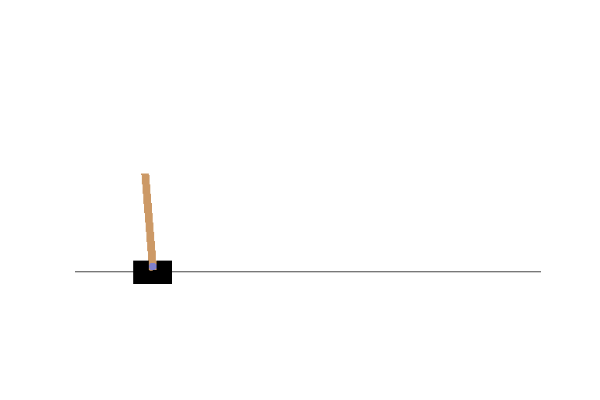
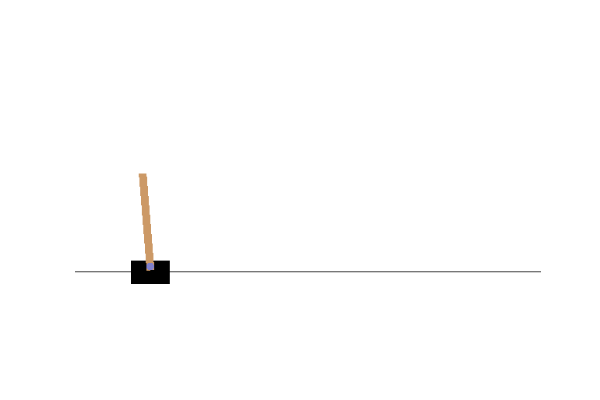
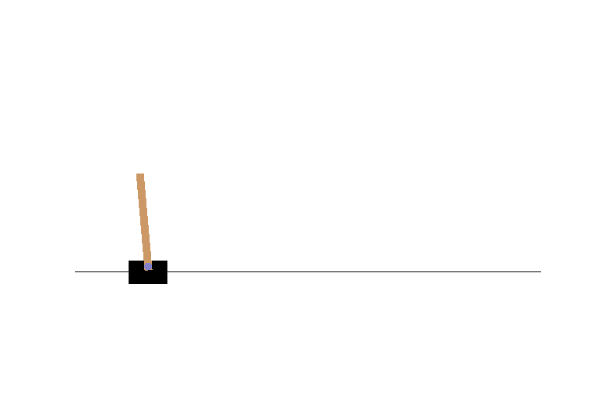
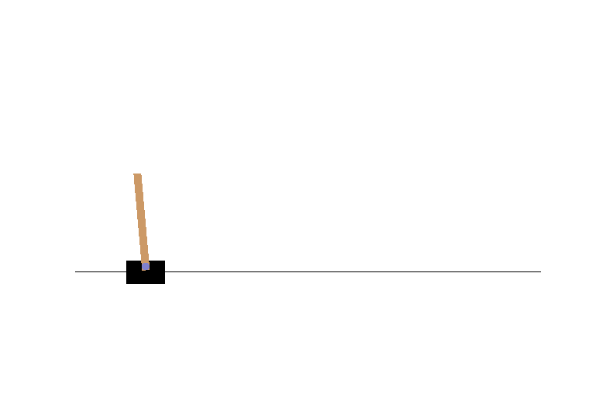
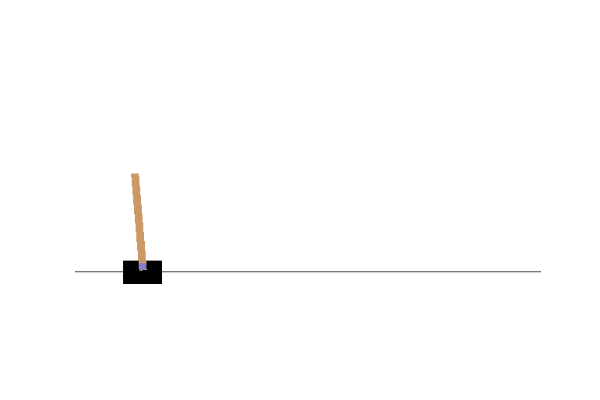
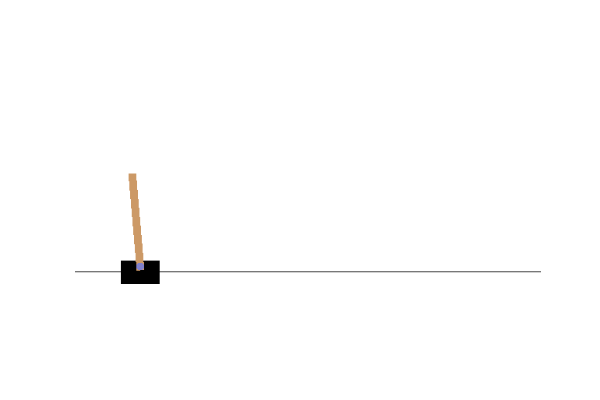
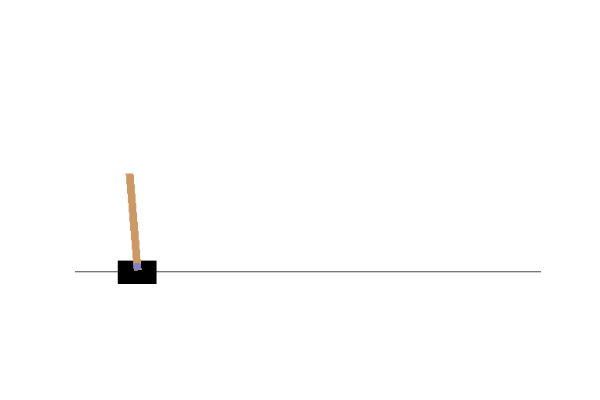
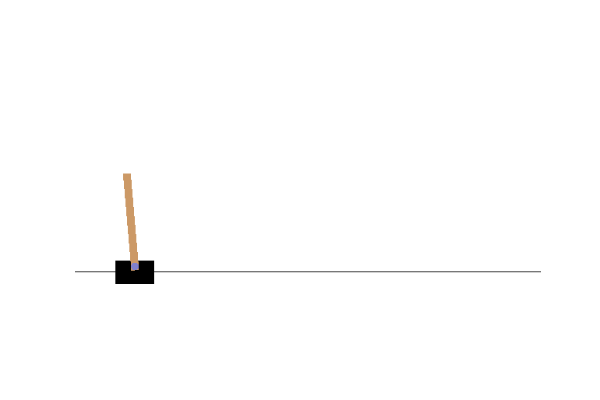
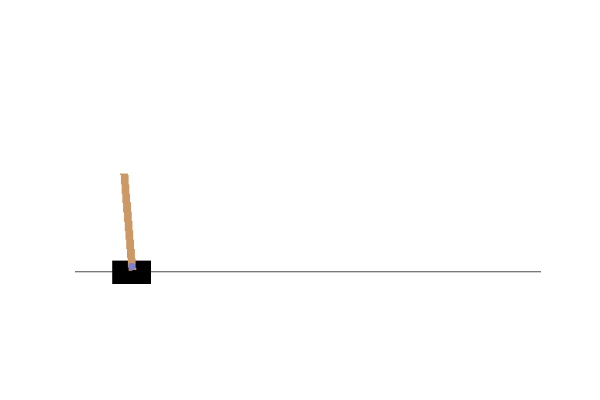
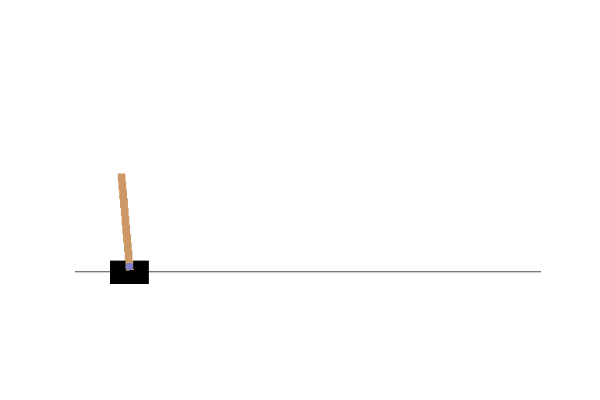
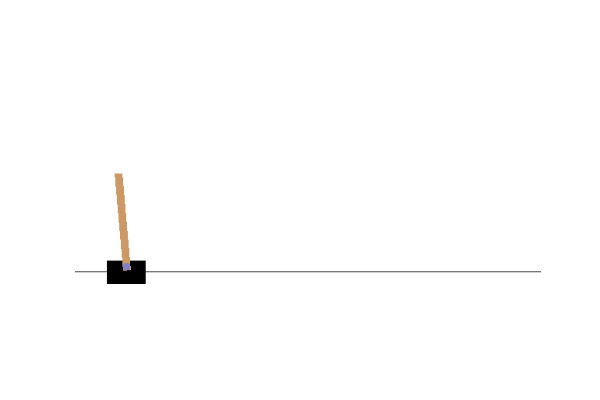
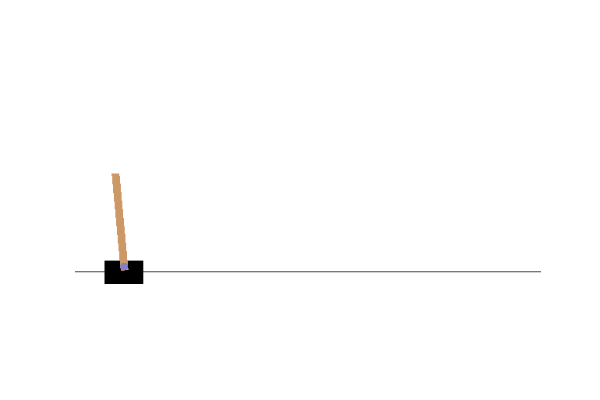
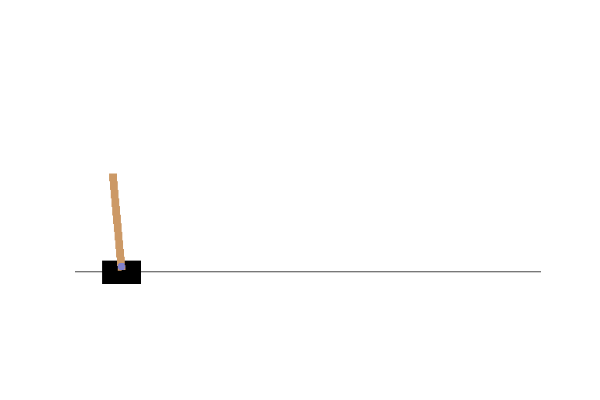
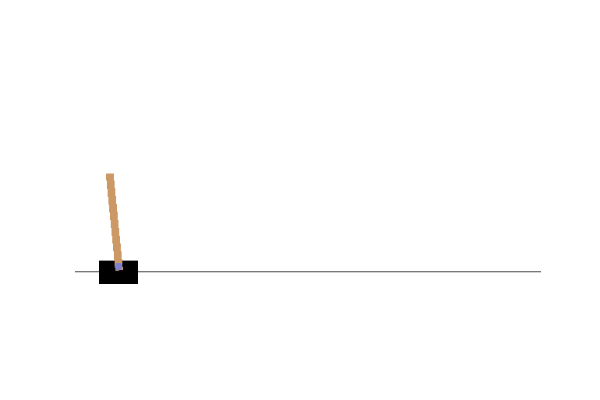
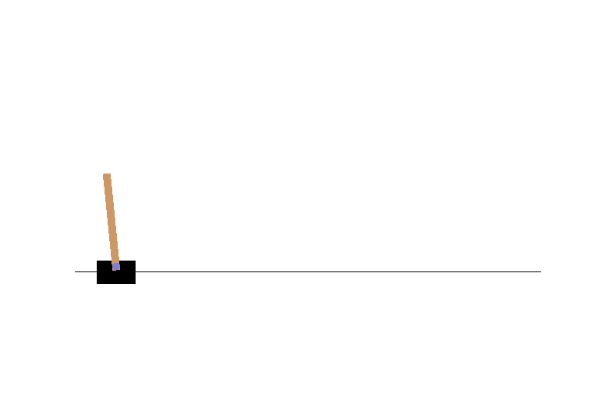
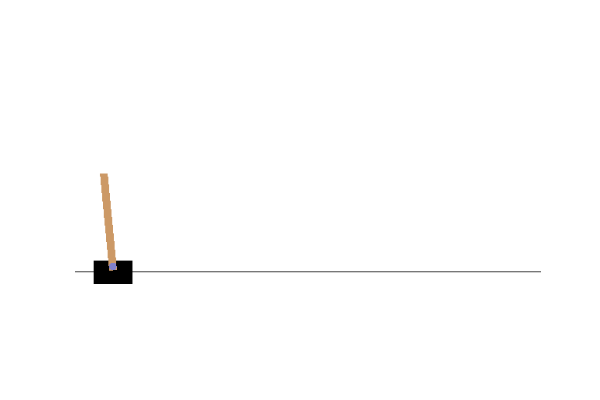
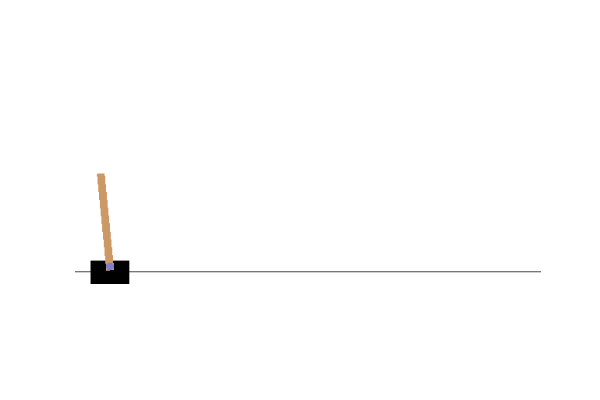
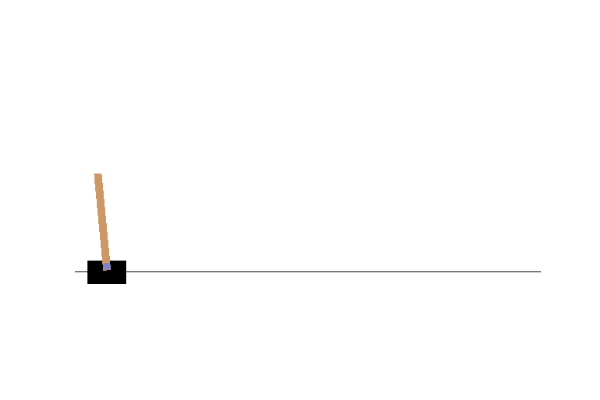
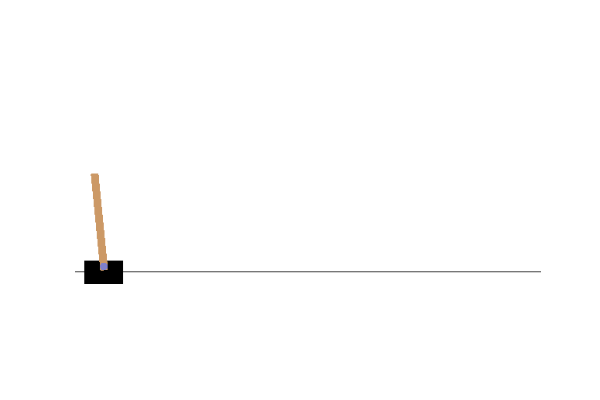
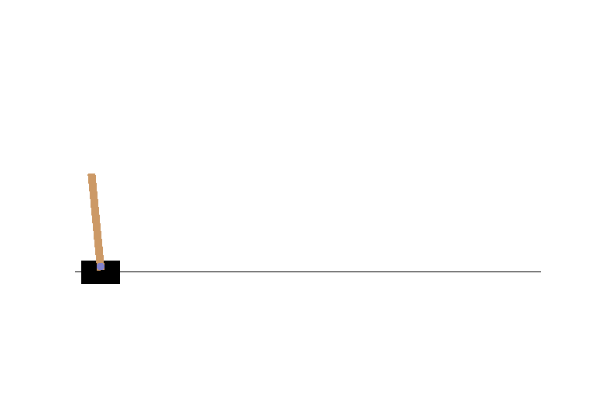
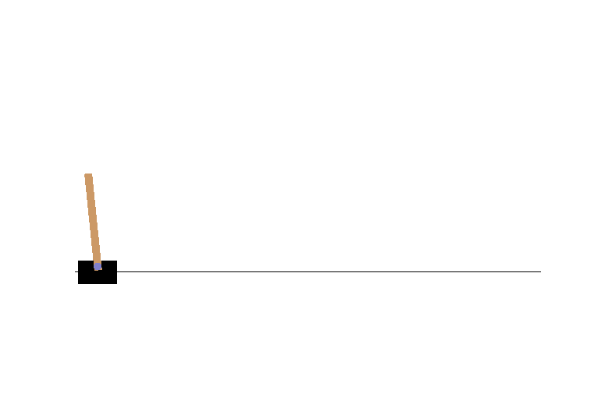
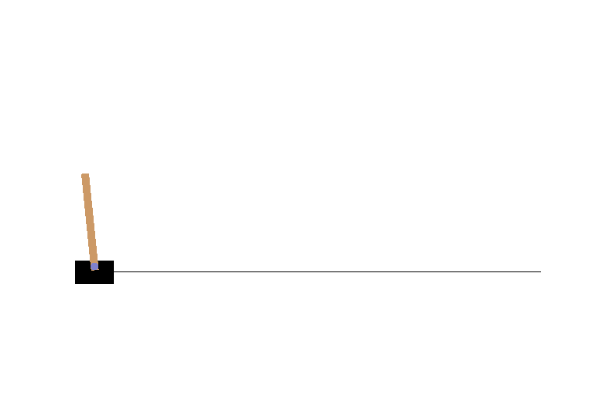
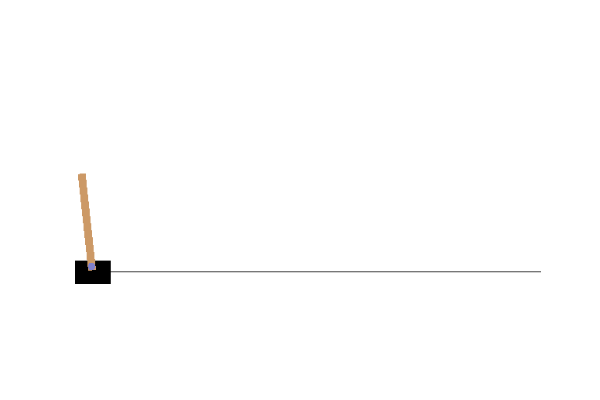
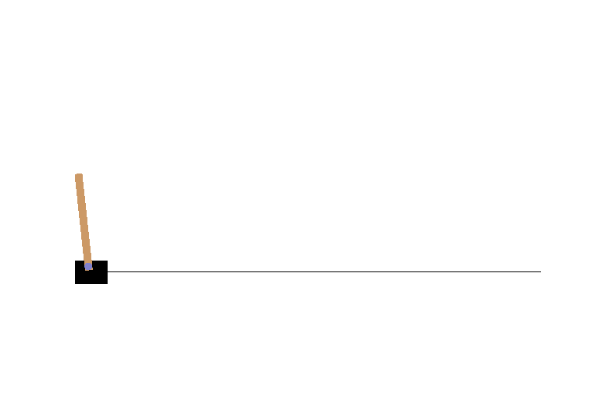
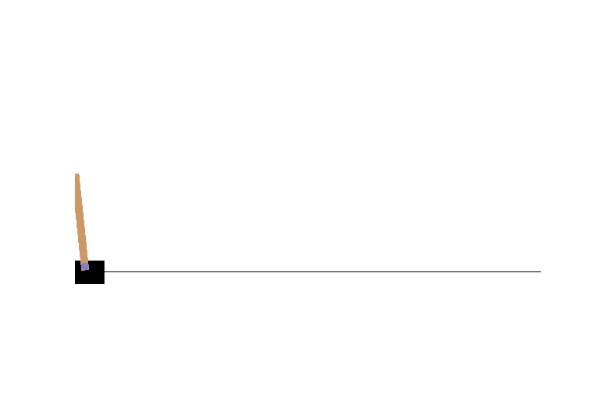
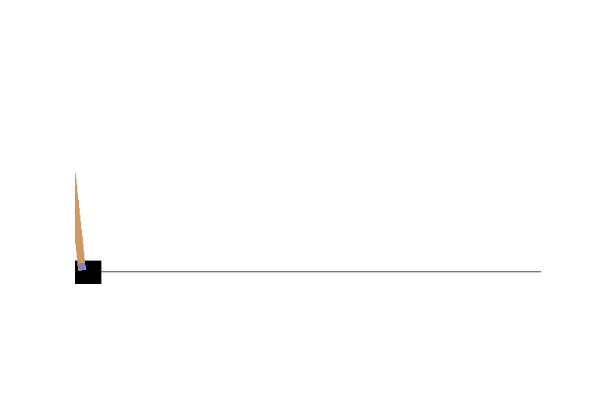
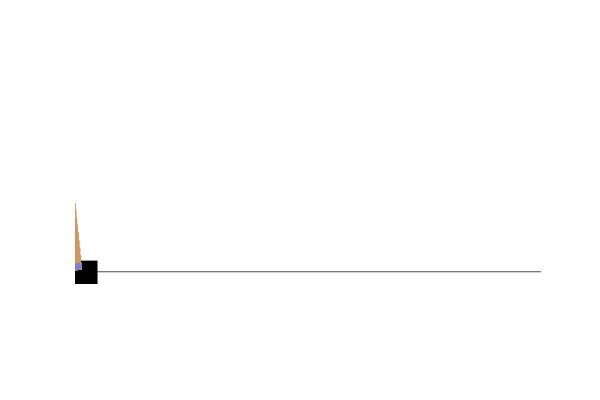
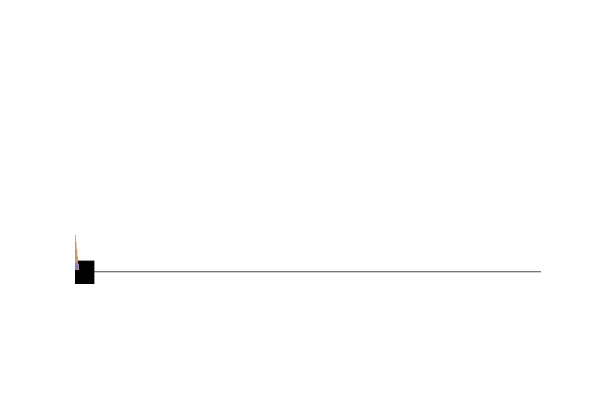

In [248]:
%matplotlib inline
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import display

import gym


def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))

display_frames_as_gif(frames)

Not bad for a first try!